## Installs and imports

In [1]:
# @title
# %pip install neptune plotly scikit-learn scipy torch seaborn tqdm multiprocess kaleido
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.linear_model import LinearRegression
import pandas as pd
import plotly.express as px
import torch
import os
import torch.optim as optim
import torch.nn.functional as F
import re
import neptune
import resource
from itertools import product
from tqdm.notebook import tqdm
import math
from functools import reduce
import torch.nn as nn

## Helper functions

#### Calculate params count

In [2]:
def calculate_total_params(dmodel, expansion_rate, n_blocks, **_):
    # assume no params in routing and embeddings
    return dmodel**2 * (9*expansion_rate + 4) * n_blocks

def calculate_active_params(dmodel, n_blocks, **_):
    return calculate_total_params(dmodel=dmodel, n_blocks=n_blocks, expansion_rate=1)

def calc_active_from_total(total_params, expansion_rate):
  return total_params / (9*expansion_rate + 4) * 13

def calc_total_from_active(active_params, expansion_rate):
  return active_params * (9*expansion_rate + 4) / 13

def calc_dmodel_from_active(active_params, depth_to_width_ratio=64):
  # active = dmodel**2 * 13 * dmodel / depth_to_width_ratio
  return (active_params*depth_to_width_ratio / 13)**(1/3)

def calc_embedd_params_from_dmodel(dmodel, vocab_size=50257):
  return 2*dmodel * vocab_size

def calc_embedd_params_from_active(active_params):
  return calc_embedd_params_from_dmodel(calc_dmodel_from_active(active_params))

def calc_tokens_rampup(steps, first_transition=7629, second_transition=11443):
  return 512*(steps * 512 - 128*np.minimum(steps, first_transition) - np.minimum(steps, second_transition) * 256)

#### Misc

In [3]:
def format_large_numbers(num):
    if abs(num) >= 1_000_000_000:
        return f'{num / 1_000_000_000:.1f}B'
    elif abs(num) >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'
    else:
        return str(num)

def present_v(v):
    if 1e6 <= v < 1e9:
        return f"{v/1e6:.2f}M"
    elif 1e9 <= v < 1e12:
        return f"{v/1e9:.2f}B"
    elif 1e12 <= v < 1e15:
        return f"{v/1e12:.2f}T"
    elif v >= 1e15:
        return f"{v:.5e}"
    elif isinstance(v, float):
        return f"{v:.6}"
    else:
        return f"{v}"

def rmse(L, L_pred):
    return torch.sqrt(torch.mean((L - L_pred) ** 2))

def get_train_valid_chunks(N, D, L, total_chunks, chunk_num):
    chunk_size = len(N) // total_chunks
    valid_start = chunk_num * chunk_size
    valid_end = valid_start + chunk_size
    N_valid = N[valid_start:valid_end]
    D_valid = D[valid_start:valid_end]
    L_valid = L[valid_start:valid_end]
    N_train = torch.cat([N[:valid_start], N[valid_end:]])
    D_train = torch.cat([D[:valid_start], D[valid_end:]])
    L_train = torch.cat([L[:valid_start], L[valid_end:]])
    return N_train, D_train, L_train, N_valid, D_valid, L_valid

def print_scaling_law(A, alpha, B, beta, E):
    A = A.item() if A is torch.Tensor else A
    alpha = alpha.item() if alpha is torch.Tensor else alpha
    B = B.item() if B is torch.Tensor else B
    beta = beta.item() if beta is torch.Tensor else beta
    e = E.item() if E is torch.Tensor else E
    print(f"Loss = {A:.2f} * -N^{alpha:.2f} + {B:.2f} * -D^{beta:.2f} + {e:.2f}")

def get_scaling_numbers(input_str):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", input_str)
    numbers = [float(i) for i in numbers]
    if len(numbers) != 5:
        raise ValueError('Input string must contain exactly 5 numbers.')
    return tuple(numbers)

In [4]:
resource.setrlimit(resource.RLIMIT_NOFILE, (1000000, 1000000))

In [5]:
def lazy_run(file_path, function, always_run=False):
    if os.path.exists(file_path) and not always_run:
        print(f"File '{file_path}' exists. Loading results from file.")
        return pd.read_csv(file_path)
    else:
        print(f"File '{file_path}' does not exist. Running the function.")
        result_df = function()
        result_df.to_csv(file_path, index=False)  # Save the DataFrame to a CSV file
        print(f"Results saved to '{file_path}'.")
        return result_df

##### Rank hyperparameters

In [6]:
def clean_dataframe(data):
    data = data[[col for col in data.columns if col.endswith('_init')]]
    data = data.loc[:, data.nunique() > 1]
    data = data.reset_index(drop=True)
    return data

def calculate_rank(data, column):
    ranks = {}
    unique_values = data[column].unique()

    for value in unique_values:
        positions = data[data[column] == value].index.to_numpy()
        average_position = positions.mean() / len(data)
        ranks[value] = average_position

    return ranks

def calculate_ranks_for_all_columns(data):
    all_ranks = {}

    for column in data.columns:
        ranks = calculate_rank(data, column)
        all_ranks[column] = ranks

    return all_ranks

def format_ranks_for_display(ranks):
  print("Scores of grid-parameters (average position, so the lower the better):\n")
  for column, values in ranks.items():
      print(f"Column: {column}")
      sorted_values = sorted(values.items(), key=lambda item: item[1])
      for value, rank in sorted_values:
          print(f"  Value: {value}, Rank: {rank:.4f}")
      print("")

### Plots

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.lines import Line2D  # For custom legend handles

def plot_pred_vs_actual(
    L,
    L_pred,
    E_train,
    L_valid=None,
    L_valid_pred=None,
    E_valid=None,
    L_test=None,
    L_test_pred=None,
    E_test=None,
    in_log=True
):
    """
    Plots predicted vs actual values for training, validation, and test datasets with color encoding based on distinct "E" values.

    Parameters:
    - L (array-like or torch.Tensor): Actual values for training.
    - L_pred (array-like or torch.Tensor): Predicted values for training.
    - E_train (array-like or torch.Tensor): "E" values for training data, used for coloring.
    - L_valid (array-like or torch.Tensor, optional): Actual values for validation.
    - L_valid_pred (array-like or torch.Tensor, optional): Predicted values for validation.
    - E_valid (array-like or torch.Tensor, optional): "E" values for validation data, used for coloring.
    - L_test (array-like or torch.Tensor, optional): Actual values for testing.
    - L_test_pred (array-like or torch.Tensor, optional): Predicted values for testing.
    - E_test (array-like or torch.Tensor, optional): "E" values for test data, used for coloring.
    - in_log (bool, default=True): If True, plots the logarithm of the values. Otherwise, plots the raw values.
    """
    # Create a figure and axis using the OO interface
    fig, ax = plt.subplots(figsize=(10, 8))

    # Helper function to convert data to numpy arrays
    def to_numpy(data):
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        elif isinstance(data, list):
            return np.array(data)
        else:
            return np.array(data)

    # Helper function to convert E values to scalars
    def to_scalar(e):
        if isinstance(e, torch.Tensor):
            return e.item()
        else:
            return e

    # Convert E_train, E_valid, E_test to numpy arrays of scalars
    E_train_np = to_numpy(E_train) if E_train is not None else None
    E_valid_np = to_numpy(E_valid) if E_valid is not None else None
    E_test_np = to_numpy(E_test) if E_test is not None else None

    # Initialize lists to collect all E values for consistent color mapping
    all_E = []
    if E_train_np is not None:
        all_E.extend(E_train_np)
    if E_valid_np is not None:
        all_E.extend(E_valid_np)
    if E_test_np is not None:
        all_E.extend(E_test_np)

    # Identify unique E values
    unique_E = sorted(list(set(all_E)))
    num_unique_E = len(unique_E)

    # Assign a distinct color to each unique E value using a discrete colormap
    # Choose 'tab10' for up to 10 unique values, 'tab20' for up to 20
    if num_unique_E <= 10:
        cmap = plt.get_cmap('tab10', num_unique_E)
    elif num_unique_E <= 20:
        cmap = plt.get_cmap('tab20', num_unique_E)
    else:
        # For more than 20 unique E values, use a larger colormap or custom colors
        cmap = plt.get_cmap('tab20', num_unique_E)
        print("Warning: More than 20 unique E values may result in color repetition.")

    # Create color_map dictionary
    color_map = {e: cmap(i) for i, e in enumerate(unique_E)}

    # Transformation function to handle torch tensors and apply log if needed
    def transform(data):
        data = to_numpy(data)
        if in_log:
            # Ensure all data is positive before applying log
            if np.any(data <= 0):
                raise ValueError("All values must be positive to apply logarithm.")
            data = np.log(data)
        return data

    # Apply transformation to all datasets
    try:
        actual_train = transform(L)
        pred_train = transform(L_pred)

        if L_valid is not None and L_valid_pred is not None and E_valid_np is not None:
            actual_valid = transform(L_valid)
            pred_valid = transform(L_valid_pred)
        if L_test is not None and L_test_pred is not None and E_test_np is not None:
            actual_test = transform(L_test)
            pred_test = transform(L_test_pred)
    except ValueError as e:
        print(f"Error in data transformation: {e}")
        return

    # Plot Training Data with circles ('o')
    scatter_train = ax.scatter(
        actual_train,
        pred_train,
        c=[color_map[e] for e in E_train_np],
        marker='o',
        label="Training",
        edgecolor='k',  # Edge color for better visibility
        alpha=0.7
    )

    # Plot Validation Data with squares ('s') if provided
    if L_valid is not None and L_valid_pred is not None and E_valid_np is not None:
        scatter_valid = ax.scatter(
            actual_valid,
            pred_valid,
            c=[color_map[e] for e in E_valid_np],
            marker='s',  # Square marker for validation
            label="Validation",
            edgecolor='k',
            alpha=0.7
        )

    # Plot Test Data with 'X' markers if provided
    if L_test is not None and L_test_pred is not None and E_test_np is not None:
        scatter_test = ax.scatter(
            actual_test,
            pred_test,
            c=[color_map[e] for e in E_test_np],
            marker='x',
            label="Test",
            alpha=0.7
            # Removed edgecolor to avoid UserWarning
        )

    # Determine the range for the reference line
    min_vals = []
    max_vals = []
    if L is not None:
        min_vals.append(actual_train.min())
        max_vals.append(actual_train.max())
    if L_valid is not None:
        min_vals.append(actual_valid.min())
        max_vals.append(actual_valid.max())
    if L_test is not None:
        min_vals.append(actual_test.min())
        max_vals.append(actual_test.max())
    min_val = min(min_vals)
    max_val = max(max_vals)

    if in_log:
        # Logarithmic ticks
        major_ticks = np.logspace(np.floor(np.log10(min_val)), np.ceil(np.log10(max_val)), num=10)
        minor_ticks = []
    else:
        # Linear ticks with major intervals of 0.1
        major_ticks = np.round(np.arange(np.floor(min_val), np.ceil(max_val) + 0.1, 0.1), 1)
        minor_ticks = np.round(np.arange(np.floor(min_val), np.ceil(max_val) + 0.05, 0.05), 1)

    # Apply major and minor ticks to the axes
    ax.set_xticks(major_ticks)
    if not in_log:
        ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    if not in_log:
        ax.set_yticks(minor_ticks, minor=True)

    # Add grid lines for both major and minor ticks
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.grid(True, which='major', linestyle='-', linewidth=0.8)

    # Plot the ideal reference line (y = x)
    ax.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Ideal")

    # Set axis labels
    ax.set_xlabel("log(Actual)" if in_log else "Actual", fontsize=14)
    ax.set_ylabel("log(Predicted)" if in_log else "Predicted", fontsize=14)

    # Create custom legend for datasets
    dataset_handles = [
        Line2D([0], [0], marker='o', color='w', label='Training',
               markerfacecolor='grey', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='s', color='w', label='Validation',
               markerfacecolor='grey', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='x', color='grey', label='Test',
               markerfacecolor='grey', markersize=10)
    ]

    # Create custom legend for E values
    E_handles = [Line2D([0], [0], marker='o', color='w', label=str(int(e) if e.is_integer() else e),
                        markerfacecolor=color_map[e], markersize=10) for e in unique_E]

    # Add legends to the plot
    legend1 = ax.legend(handles=dataset_handles, title="Dataset", loc='upper left')
    ax.add_artist(legend1)  # Add the first legend manually
    ax.legend(handles=E_handles, title="E Values", loc='lower right')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()


# Downloading Data from Neptune



#### Functions

In [8]:
def download_from_neptune(tag):
  project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNDYxZjgzZC0xYTljLTQwZGQtOTVjNC02MTI5ZTc4ZjBiNGIifQ=="
  )
  df = project.fetch_runs_table(tag=f"{tag}").to_pandas()
  df.drop(list(df.filter(regex = 'monitoring')), axis = 1, inplace = True)
  return df


def is_token_exponential(token_count):
  log_tokens = np.log2(token_count/1e9)
  print(f"{np.unique(np.round(log_tokens, 1))=}")
  return np.round(log_tokens, 1) == np.round(log_tokens, 0)


def get_full_table(raw_table, name, exp_rate=None, tokens_counted_per_active=False, tokens_counted_per_total=False, table=None, negative_tags=None, granularities=None,
                   use_active=False, loss_column="loss_interval/10", with_embeddings=False, thresh_active=(-np.inf, np.inf), thresh_length=(-np.inf, np.inf), filter_non_exp_d=False,
                   thresh_token_to_param_ratio=(-np.inf, np.inf), loss_thresh=(-np.inf, np.inf), attn_heads_to_remove=()):

  table = raw_table[raw_table["args/name"] == name]
  table = table[table["sys/state"] == "Inactive"]
  table = table[table["lr"]==0]  # finished trapezoid schedule
  table["loss"] = table[loss_column]
  table = table[np.isfinite(table["loss"])]


  table["total_params"] = table.apply(lambda row: calculate_total_params(row["args/dmodel"], row["args/expansion_rate"], row["args/n_blocks"]), axis=1)
  table["active_params"] = table.apply(lambda row: calculate_active_params(dmodel=row["args/dmodel"], n_blocks=row["args/n_blocks"]), axis=1)
  table["params"] = table["active_params"] if use_active else table["total_params"]
  table["tokens"] = calc_tokens_rampup(table["step"])

  table["embed_params"] = calc_embedd_params_from_dmodel(table["args/dmodel"])

  table["active_with_embed"] = table["active_params"] + table["embed_params"]
  table["total_with_embed"] = table["total_params"] + table["embed_params"]

  if with_embeddings:
    table["params"] += table["embed_params"]

  table["str_active_non_embed"] = table["active_params"].apply(format_large_numbers)
  table["str_params"] = table["params"].apply(format_large_numbers)
  table["str_tokens"] = table["tokens"].apply(format_large_numbers)


  # filters
  if filter_non_exp_d:
    table = table[is_token_exponential(table["tokens"])]

  for attn_heads in attn_heads_to_remove:
    table = table[table["args/n_att_heads"] != attn_heads]

  table = table[table.apply(lambda x:not "remove_constrained_scaling_laws" in x["sys/tags"],axis=1)]
  if exp_rate != None:
      if not isinstance(exp_rate, list):
          exp_rate = [exp_rate]
      table = table[table["args/expansion_rate"].isin(exp_rate)]

  table = table[table["active_params"] >= thresh_active[0]]
  table = table[table["active_params"] <= thresh_active[1]]
  table = table[table["tokens"] >= thresh_length[0]]
  table = table[table["tokens"] <= thresh_length[1]]
  table = table[table["tokens"] / table["active_params"] >= thresh_token_to_param_ratio[0]]
  table = table[table["tokens"] / table["active_params"] <= thresh_token_to_param_ratio[1]]
  table = table[table["loss"] >= loss_thresh[0]]
  table = table[table["loss"] <= loss_thresh[1]]

  if tokens_counted_per_active:
    table["tokens"] = table["tokens"] / table["active_params"]
  elif tokens_counted_per_total:
    table["tokens"] = table["tokens"] / table["total_params"]

  print(f"Number of experiments: {len(table)}")
  print("All sizes and token counts in table:")
  print(table["str_params"].unique())
  print(table["str_tokens"].unique())
  return table

In [9]:
def extract_params(table, name="Train"):
  print(f"{name} size: {len(table)}")
  print(f"{name} params: {table['str_params'].unique()}")
  min_loss, max_loss = table["loss"].min(), table["loss"].max()
  print(f"{name} losses interval: ({min_loss:.4f}, {max_loss:.4f}")
  return (torch.Tensor(table["params"].tolist()).requires_grad_(False),
          torch.Tensor(table["tokens"].tolist()).requires_grad_(False),
          torch.Tensor(table["loss"].tolist()).requires_grad_(False),
          torch.Tensor(table["args/expansion_rate"].tolist()).requires_grad_(False))

def get_train_test_values(table, topn_losses_for_test):
  N_test = D_test = L_test = E_test = None

  if topn_losses_for_test is not None:
    unique_losses = table["loss"].unique()
    test_sizes = unique_losses[np.argsort(unique_losses)[:topn_losses_for_test]].tolist()

    split_condition = table["loss"].isin(test_sizes)
    test_table = table[split_condition]
    train_table = table[~split_condition]
    assert len(train_table) + len(test_table) == len(table)

    N_test, D_test, L_test, E_test = extract_params(test_table, "Test")
    table = train_table

  N, D, L, E = extract_params(table)
  return N, D, L, E, N_test, D_test, L_test, E_test

: 

### Fetch dataset (slow)

In [ ]:
raw_table = lazy_run("neptune_data_const.csv", lambda: download_from_neptune("constrained_scaling_grid"))

File 'neptune_data_const.csv' does not exist. Running the function.
https://app.neptune.ai/pmtest/llm-random/


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbf604857f0>>
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/llmrandom/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# Scaling Formula


### Predict scaling law


#### Predict functions in log

In [11]:
def predict_loss_in_log(N, a, alpha, D, b, beta, c, Nb=None, Nb_a=torch.nan, Nb_alpha=0, **_):
    if Nb is None:
      Nb = calc_embedd_params_from_active(N)
    if c.shape != D.shape:
        c = c.repeat(D.shape[0])
    parts = [a-alpha*torch.log(N), b-beta*torch.log(D), c]
    if isinstance(Nb_a, torch.Tensor) and not torch.isnan(Nb_a):
      parts.append(Nb_a-Nb_alpha*torch.log(Nb))
    return torch.logsumexp(torch.stack(parts), 0)

def map_separate_params(chinchilla_params, E, Nb_a=torch.nan, Nb_alpha=0, **other_params):
  E_rounded = (2**torch.round(torch.log2(E))).to(torch.int)

  for key in chinchilla_params.keys():
    if len(E.shape) > 0:
      for i, e in enumerate(E_rounded):
        value = other_params.get(f"{key}_{e}", math.nan)
        if not math.isnan(value):
          chinchilla_params[key][i] = value
    else: #  2**int(round(torch.log2(E).item()))
        value = other_params.get(f"{key}_{E_rounded}", math.nan)
        if not math.isnan(value):
          chinchilla_params[key] = value

  if isinstance(Nb_a, torch.Tensor) and not torch.isnan(Nb_a):
    chinchilla_params["Nb_a"] = Nb_a
    chinchilla_params["Nb_alpha"] = Nb_alpha

def project_joined_to_chinchilla_in_log(a, b, c, alpha, beta, gamma, delta, omega, zeta, E, e_start, e_end, **other_params):
  e_start = torch.exp(-e_start)
  e_end = torch.exp(-e_end)
  e_dash = torch.log((E - 0.99 + (e_start - e_end)**-1)**-1 + e_end)

  a_e = a + delta*e_dash
  b_e = b + omega*e_dash
  alpha_e = (alpha - e_dash*gamma)
  beta_e = (beta - e_dash*zeta)

  chinchilla_params = {"a":a_e, "b":b_e, "c":c, "alpha": alpha_e, "beta": beta_e}
  map_separate_params(chinchilla_params, E, **other_params)
  return chinchilla_params

def predict_loss_joined_in_log(N, D, E, Nb=None, **params):
    return predict_loss_in_log(N=N, D=D, Nb=Nb, **project_joined_to_chinchilla_in_log(E=E, **params))

#### Wrappers for evaluating normal functions in log

In [12]:
def predict_loss_torch(N, A, alpha, D, B, beta, C, Nb=None, Nb_a=torch.nan, Nb_alpha=0, **_):
    if N is None or D is None or E is None:
        return None
    return torch.exp(predict_loss_in_log(N=N, a=torch.log(A), alpha=alpha, D=D, b=torch.log(B), beta=beta, c=torch.log(C), Nb_a=Nb_a, Nb_alpha=Nb_alpha, Nb=Nb))

def predict_loss_joined_torch(N, D, E, A, B, C, **params):
    if N is None or D is None or E is None:
        return None
    return torch.exp(predict_loss_joined_in_log(N=N, D=D, E=E, a=torch.log(A), b=torch.log(B), c=torch.log(C), **params))

def project_joined_to_chinchilla_torch(A, B, C, **params):
    params = project_joined_to_chinchilla_in_log(a=torch.log(A), b=torch.log(B), c=torch.log(C), **params)
    add_params = {}
    if "Nb_a" in params:
      add_params = {"Nb_a": params["Nb_a"], "Nb_alpha": params["Nb_alpha"]}
    return {"A":torch.exp(params["a"]), "B":torch.exp(params["b"]), "C":torch.exp(params["c"]), "alpha": params["alpha"], "beta": params["beta"], **add_params}

#### Wrappers for numpy

In [13]:
def change_all_to_torch(**args):
    return {k: torch.tensor(v) if isinstance(v, np.generic) or isinstance(v, np.ndarray) or isinstance(v, float) or isinstance(v, int)  else v for k, v in args.items()}

def change_all_to_numpy(**args):
    return {k: v.numpy() for k, v in args.items()}

def project_joined_to_chinchilla(**params):
    return change_all_to_numpy(**project_joined_to_chinchilla_torch(**change_all_to_torch(**params)))

def predict_loss(**params):
    w = predict_loss_torch(**change_all_to_torch(**params))
    return w.numpy() if isinstance(params["N"], np.ndarray) else w

def predict_loss_joined(**params):
    w = predict_loss_joined_torch(**change_all_to_torch(**params))
    return w.numpy() if isinstance(params["N"], np.ndarray) else w

### Joint Scaling Law Fitting

$ L_{Ch}(N, D) = aN^{-\alpha} + bD^{-\beta} + c $


$ L(N, D, E') = aN^{\alpha}E'^{\delta + \gamma log(N) } + bD^{\beta}E'^{\omega + \zeta log(D)} + c $

equivalent form:

$L(N, D, E') = {a{E'}^{\delta}}N^{\alpha + {\gamma}{\texttt{log}}(E')} + {b{E'}^{\omega}}D^{\beta + {\zeta}{\texttt{log}}(E')} + c$


$ L(N, D, E') = a(E) N^{\alpha(E)} + b(E) D^{\beta(E) } + c. $

for

$a(E')=a{E'}^{\delta}$, $\alpha(E')={\alpha + {\gamma}{\texttt{log}}(E')}$, $b(E')=b{E'}^{\omega}$, $\beta(E')={\beta + {\zeta}{\texttt{log}}(E')}$


$\frac{1}{E'} = \frac{1}{E +\mathbf{1}_{E=1}\phi - 1 + \left(\frac{1}{E_{start}} - \frac{1}{E_{max}}\right)^{-1}} + \frac{1}{E_{max}},$


In [14]:
def get_example_weight(log_L, N, D, loss_weight, pareto_distance_weigth):
    example_weight = (log_L ** loss_weight)
    example_weight *= (torch.clamp(40*N/D, max=1))**pareto_distance_weigth
    example_weight = example_weight/example_weight.sum() * len(example_weight)
    return example_weight

def compute_joined_scaling_law(N, a, alpha, D, b, beta, c, E, delta, gamma, omega, zeta, L, huber_delta, Nb_a=np.nan, Nb_alpha=0, e_start=1.0, e_end=1.0, e_a_conv=1.0, e_b_conv=1.0, e_1_param=1.0, e_2_param=0.0, e_1_term=0, e_1_special=False,
                               weight_decay=0, optimize_c=False, lr=0.1, alternative_form=True, with_estart=False, with_eend=False, with_e_conv=True, loss_weight=0, pareto_distance_weigth=0.,
                               history_size=10000, max_iter=100000, line_search_fn="strong_wolfe", steps=1, separate_chinchillas_for=(), tolerance_change=1e-9, tolerance_grad=1e-7, **add_params):
    """
    params:
    N, a, alpha, D, b, beta, e: initial values for the parameters of the scaling law
    huber_delta: delta parameter for the Huber loss
    weight_decay: weight decay parameter for the L1 regularization
    separate_chinchillas_for: tuple of expansion rates for a separate chinchillas
    """
    create_tensor = lambda val, log=False, grad=True: torch.tensor([math.log(val) if log else val], dtype=torch.float64).requires_grad_(grad)

    N, D, L, E = [x.to(torch.float64) for x in [N, D, L, E]]

    params_dict = {
        "a": create_tensor(a, log=True),
        "b": create_tensor(b, log=True),
        "c": create_tensor(c, log=True, grad=optimize_c),
        "alpha": create_tensor(alpha), "beta": create_tensor(beta),  "delta": create_tensor(delta),
        "gamma": create_tensor(gamma), "omega": create_tensor(omega), "zeta": create_tensor(zeta),
        "e_start": create_tensor(e_start, log=True, grad=with_estart),
        "e_end": create_tensor(e_end, log=True, grad=with_eend),
        **{k: create_tensor(v) for k, v in add_params.items()},
    }

    if not np.isnan(Nb_a):
      params_dict["Nb_a"] = create_tensor(Nb_a, log=True)
      params_dict["Nb_alpha"] = create_tensor(Nb_alpha)

    for separate_E in separate_chinchillas_for:
      for base_param in ['a', 'b', 'alpha', 'beta']:
        params_dict[f"{base_param}_{separate_E}"] =  nn.Parameter(params_dict[base_param].clone())

    params = params_dict.values()

    def objective():
        inp = predict_loss_joined_in_log(N=N, D=D, E=E, **params_dict)
        target = torch.log(L)
        example_weight = get_example_weight(target, N, D, loss_weight, pareto_distance_weigth)
        loss = F.huber_loss(inp, target, delta=huber_delta, reduction='none') * example_weight
        loss = loss.sum()
        l2_reg = sum([param.sum()**2 for param in params])
        loss += weight_decay * l2_reg
        return loss

    def closure():
        lbfgs.zero_grad()
        loss = objective()
        loss.backward()
        return loss

    lbfgs = optim.LBFGS(params,
                        history_size=history_size,
                        lr=lr,
                        max_iter=max_iter,
                        tolerance_change=tolerance_change,
                        tolerance_grad=tolerance_grad,
                        line_search_fn=line_search_fn)
    for i in range(steps):
      lbfgs.step(closure)

    return_dict = dict(
        **params_dict,
        A = torch.exp(params_dict['a']),
        B = torch.exp(params_dict['b']),
        C = torch.exp(params_dict['c']),
    )
    del return_dict['a']
    del return_dict['b']
    del return_dict['c']

    return_dict =  {
        key: (value.detach() if isinstance(value, torch.Tensor) else value)
        for key, value in return_dict.items()
    }

    return return_dict

### Compute optimal curve calculation

In [15]:
def get_optimal_config_for_flops(A, alpha, B, beta, flops, **_):
    a = beta / (alpha + beta)
    b = alpha / (alpha + beta)
    G = (alpha*A / (beta*B)) ** (1 / (alpha + beta))
    d_opt = (flops / 6) ** b / G
    n_opt = (flops / 6) ** a * G
    return n_opt, d_opt, a, b

def binsearch(eval, start, end, tolerance=1e-5):
    mid = (start + end) / 2
    if abs(end - start) <= tolerance:
        return mid
    elif eval(mid) > 0:
        return binsearch(eval, start, mid, tolerance)
    else:
        return binsearch(eval, mid, end, tolerance)

def calc_flops(N, D):
    Nb = calc_embedd_params_from_active(N)
    return 6 * (N + Nb) * D

def calc_D_from_active(N, flops):
    Nb = calc_embedd_params_from_active(N)
    D = flops / (6 * (N + Nb))
    return D

def calc_compute_optimal(flops, single_chinchilla_params=None, **params):
    if single_chinchilla_params is not None:
      n_opt, d_opt, a, b = get_optimal_config_for_flops(**single_chinchilla_params, flops=flops)
      return n_opt, 0, d_opt  # this does not calculate separate embeddings but we dont need them

    predict = lambda N,D: predict_loss_joined(N=N, D=D, **params)
    predict_loss_for_N = lambda N: predict(N, calc_D_from_active(N, flops))
    #print(f"{flops=} {predict_loss_for_N(1e8)=} {predict_loss_for_N(1e9)=}")
    N = (10**(binsearch(lambda logN: - predict_loss_for_N(10**logN) + predict_loss_for_N((10**logN)*1.01), 3, 40, 1e-3)))*1.005
    D = calc_D_from_active(N, flops)
    Nb = calc_embedd_params_from_active(N)
    return N, Nb, D


def get_optimal_D_for_N_with_embeddings(N_with_emb, **params):
    flops = 10**binsearch(lambda log_flops: sum(calc_compute_optimal(10**log_flops, **params)[:2]) - N_with_emb, 3, 60, 1e-3)
    return calc_compute_optimal(flops, **params)[-1]


def get_optimal_D_for_N_no_emb(N, **params):
    flops = 10**binsearch(lambda log_flops: calc_compute_optimal(10**log_flops, **params)[0] - N, 3, 60, 1e-3)
    return calc_compute_optimal(flops, **params)


def print_compute_optimal_configs_for_N_no_emb(Ns, **params):
  for N in Ns:
      N_, Nb, D = get_optimal_D_for_N_no_emb(N, **params)
      assert abs(N_ - N)/N < 0.2
      print(f"Optimal for N (active no embeddings) {present_v(N):7} : D: {present_v(D):7}, embeddings Nb: {present_v(Nb):7}  D/N: {present_v(D/(N)):7} ")

def print_compute_optimal_configs_for_N_with_emb(N_with_embs, single_chinchilla_params, **params):
  for N_with_emb in N_with_embs:
      D = get_optimal_D_for_N_with_embeddings(N_with_emb, single_chinchilla_params=single_chinchilla_params, **params)
      print(f"Optimal for N (with embeddings) {present_v(N_with_emb):7} : D: {present_v(D):7} D/N: {present_v(D/(N_with_emb)):7} ")

def print_compute_optimal_configs_for_N(Ns, with_embeddings, single_chinchilla_params, **params):
  if with_embeddings:
    print_compute_optimal_configs_for_N_with_emb(Ns, single_chinchilla_params=single_chinchilla_params, **params)
  else:
    print_compute_optimal_configs_for_N_no_emb(Ns, **params)

def print_compute_optimal_configs_for_flops_binsearch(flop_budgets, with_embeddings, **params):
  for flops in flop_budgets:
    N, Nb, D = calc_compute_optimal(flops, **params)
    print(f"Optimal for {flops:10} FLOPs: N: {present_v(N):10}, Nb: {present_v(Nb):10}, D: {present_v(D):10} D/N: {present_v(D/N)}")

def print_chinchilla_optimal_configs_from_formula(A, alpha, B, beta, flop_budgets, **_):
    for flop_budget in flop_budgets:
        n_opt, d_opt, a, b = get_optimal_config_for_flops(A, alpha, B, beta, flop_budget)
        print(f"Optimal for {flop_budget} FLOPs: N: {present_v(n_opt)}, D: {present_v(d_opt)} D/N: {present_v(d_opt/n_opt)}")
    return a, b

def print_compute_optimal_configs_for_flops(flop_budgets, with_embeddings, single_chinchilla_params, **params):
  if with_embeddings:
    print_chinchilla_optimal_configs_from_formula(**single_chinchilla_params, flop_budgets=flop_budgets)
  else:
    print_compute_optimal_configs_for_flops_binsearch(flop_budgets, with_embeddings, **params)


## Fit the curve with inits grid

In [16]:
import multiprocessing as mp
import threading
import time
from typing import Callable, Any
from tqdm.cli import tqdm

from concurrent.futures import ProcessPoolExecutor

# Ensure spawn is the default context
mp.set_start_method('fork', force=True)


def calculate_params_for_init_dicts(grid_init_dicts, **other_params):
  for init_grid in grid_init_dicts:
      yield init_grid, compute_joined_scaling_law(**init_grid, **other_params)

def compute_no_kwargs(args):
  i, init_grid, other_params = args
  w = None
  while w is None:
      try:
        #print(f"worker {i} started")
        w = init_grid, compute_joined_scaling_law(**init_grid, **other_params)
        #print(f"worker {i} finished")
      except Exception as ex:
        print(f" Exception {ex}", flush=True)
      except:
        print(f" Exception unknown", flush=True)
  return w

def calculate_params_for_init_dicts_multithreaded(grid_init_dicts, cores, **other_params):
  print(f"\nRunning concurrently {len(grid_init_dicts)} jobs with {cores=}")

  args = [(i, init_grid, other_params) for i, init_grid in enumerate(grid_init_dicts)]

  with mp.Pool(cores) as pool:
      for result in pool.imap_unordered(compute_no_kwargs, args):
         if result is not None:
            yield result


def timeout_wrapper(args) -> Any:
    result_container = [None]  # To hold the result of the function call

    def target():
        try:
            result_container[0] = compute_no_kwargs(*args)
        except Exception as e:
            print(f" Exception thread {ex}")

    thread = threading.Thread(target=target)
    thread.start()
    thread.join(60)

    if thread.is_alive():
        return None  # Indicate timeout occurred

    return result_container[0]  # Return the function's result or exception

def calculate_joined_scaling_law(N, D, L, E, N_test, D_test, L_test, E_test, inits, cores=None, optimize_c=True):
  grid_init_dicts = [dict(zip(inits.keys(), values)) for values in product(*inits.values())]
  total_iterations = len(grid_init_dicts)

  if cores is None:
      cores = min(mp.cpu_count(), total_iterations, 80)

  calculate_function = calculate_params_for_init_dicts if cores == 1 else calculate_params_for_init_dicts_multithreaded
  opt_values_for_inits = calculate_function(grid_init_dicts, cores=cores, N=N, D=D, L=L, E=E, optimize_c=optimize_c)

  df = pd.DataFrame(columns=[])
  pbar = tqdm(total=total_iterations, dynamic_ncols=True, smoothing=0)
  for i, (init_dict, opt_values) in enumerate(opt_values_for_inits):
      predicted_loss = predict_loss_joined(N=N, D=D, E=E, **opt_values)
      #print(f"{i}/{total_iterations} done")
      temp_df = pd.DataFrame([{
          "train_score": rmse(torch.log(L), torch.log(predicted_loss)).item(),
          "test_score": rmse(torch.log(L_test), torch.log(predict_loss_joined(N=N_test, D=D_test, E=E_test, **opt_values))).item() if E_test is not None else None,
          **{k: v.item() for k, v in opt_values.items()},
          **{f"{k}_init": v for k, v in init_dict.items()}
      }])
      df = pd.concat([df, temp_df], ignore_index=True)
      pbar.update(1)
  pbar.close()
  return df

# Run

## Joint fitting

### Configuration

In [17]:
data_filters = dict(
    name="constrained_scaling_grid_21_11",
    thresh_active=(1e7, np.inf),
    thresh_length=(-np.inf, np.inf),
    thresh_token_to_param_ratio=(-np.inf, 100),
    loss_thresh=(-np.inf,  np.inf),
    exp_rate=[1, 2, 4, 8, 16, 32],
    attn_heads_to_remove=[],
    use_active=True,
    with_embeddings=True,
    filter_non_exp_d=False,
    tokens_counted_per_active=False,
    tokens_counted_per_total=False,
    #loss_column="loss_interval/100",
    loss_column="final_eval_capacity_factor_1.5",
    #loss_column="final_eval",
)

In [18]:
inits_experimental = dict(
    lr = [0.0001], #, 0.00001],
    huber_delta = [0.01],
    weight_decay = [1e-5],
    loss_weight = [-30], #, -20, -30, -50, -10],
    pareto_distance_weigth = [0], #2, 1, 0.1], #, 3, 5],

    alpha = [0.25, 0.5, 0.05], # ], #
    beta = [0.25, 0.5, 0.05],
    a = [100, 30, 300], #, 1], #], #
    b = [100, 30, 300], #, 1], #],
    c = [2, 1, 0.5], #, 0.2],
    delta = [0.0, 0.5, -0.5], #
    gamma = [0.0, 0.5, -0.5],
    omega = [0.0, -0.5, 0.5],
    zeta = [0.0, -0.5, 0.5],
    e_start=[1], #, 1], #, 2, 5],
    e_end = [300], #, 500], #, 10, 5],

    Nb_a = [np.nan], #[5, 1, 30],  # np.nan to turn separate params for embeddings off
    #Nb_alpha = #[0.25, 0.5, 0.05],
    history_size=[20000],
    max_iter=[10000],
    line_search_fn=["strong_wolfe"], # ["strong_wolfe"]
    with_estart=[True],
    with_eend=[True],
    tolerance_change=[1e-10],
    tolerance_grad=[1e-10],
    #separate_chinchillas_for=[(1, 2, 4, 8, 16, 32),],
)

trim_to = 2  # we assume that first value from the list was some previous SOTA
inits_best = {k: v[:trim_to] for k, v in inits_experimental.items()}

inits = inits_experimental

In [19]:
table = get_full_table(raw_table, **data_filters)
table = table[~((table["str_active_non_embed"]=="340.8M") & (table["args/expansion_rate"] == 16))]
table = table[~((table["str_params"]=="2.7B") & (table["args/expansion_rate"] == 2))]
N, D, L, E, N_test, D_test, L_test, E_test = get_train_test_values(table=table, topn_losses_for_test=10)

Number of experiments: 282
All sizes and token counts in table:
['890.5M' '426.3M' '708.5M' '1.1B' '1.6B' '1.3B' '2.7B' '554.6M' '96.7M'
 '141.6M' '200.6M' '469.4M' '682.7M' '169.2M' '321.0M' '117.6M' '78.7M']
['9.9B' '5.0B' '31.0B' '25.9B' '21.8B' '18.7B' '15.6B' '14.0B' '12.0B'
 '10.0B' '5.4B' '2.7B' '6.5B' '3.3B' '35.3B' '12.2B' '10.6B' '7.7B' '5.3B'
 '3.8B' '11.1B' '5.6B' '2.8B' '2.0B' '18.6B' '4.0B' '9.2B' '5.5B' '1.4B'
 '980.0M' '16.0B' '8.0B' '12.5B' '6.2B' '1.7B' '4.5B' '2.3B' '1.1B' '6.4B'
 '3.2B' '1.6B' '800.0M' '20.7B' '10.4B' '5.2B' '2.6B' '1.3B' '49.8B'
 '24.9B' '3.1B' '778.0M' '32.0B' '999.9M' '500.0M' '80.0B' '64.0B' '48.0B']
Test size: 10
Test params: ['708.5M' '1.1B']
Test losses interval: (2.3786, 2.5212
Train size: 260
Train params: ['890.5M' '426.3M' '708.5M' '1.1B' '1.6B' '1.3B' '2.7B' '554.6M' '96.7M'
 '141.6M' '200.6M' '469.4M' '682.7M' '169.2M' '321.0M' '117.6M' '78.7M']
Train losses interval: (2.5233, 3.5397


### Fit

In [20]:
scores_df = lazy_run("scores_df.csv",
         lambda: calculate_joined_scaling_law(N=N, D=D, L=L, E=E, N_test=N_test, D_test=D_test, L_test=L_test, E_test=E_test, inits=inits, optimize_c=True),
        #  always_run=True)  # set to false to reuse previous data
         always_run=False)  # set to false to reuse previous data

File 'scores_df.csv' exists. Loading results from file.


In [21]:
scores_df["score"] = scores_df["test_score"] * 5/10 + scores_df["train_score"] * 5/10
# scores_df["score"] = scores_df["train_score"]
scores_df = scores_df.sort_values(by="score")
scores_df = scores_df.reset_index(drop=True)
best_result = scores_df.index[0]
res = scores_df.loc[best_result]
print(res)
df = scores_df
scores_df.head(10)

train_score                        0.006219
test_score                         0.003915
alpha                               0.18893
beta                               0.177532
delta                              0.228513
gamma                             -0.009798
omega                             -0.552916
zeta                                0.02585
e_start                            0.729077
e_end                              5.671439
A                                 35.907456
B                                 35.979302
C                                   1.36374
lr_init                              0.0001
huber_delta_init                       0.01
weight_decay_init                   0.00001
loss_weight_init                        -30
pareto_distance_weigth_init               0
alpha_init                             0.25
beta_init                               0.5
a_init                                   30
b_init                                   30
c_init                          

,train_score,test_score,alpha,beta,delta,gamma,omega,zeta,e_start,e_end,...,e_end_init,Nb_a_init,history_size_init,max_iter_init,line_search_fn_init,with_estart_init,with_eend_init,tolerance_change_init,tolerance_grad_init,score
0,0.006219,0.003915,0.188930,0.177532,0.228513,-0.009798,-0.552916,0.025850,0.729077,5.671439,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005067
1,0.006442,0.003780,0.188267,0.173393,0.239089,-0.010351,-0.504106,0.023523,0.637499,5.691853,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005111
2,0.006431,0.003795,0.187891,0.173962,0.240179,-0.010429,-0.507899,0.023710,0.632426,5.691765,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005113
3,0.006428,0.003915,0.189122,0.174703,0.286498,-0.013270,-0.582253,0.027534,0.593296,5.691712,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005172
4,0.006732,0.003709,0.191787,0.179232,0.121016,-0.003710,-0.400513,0.018027,0.361699,5.667003,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005221
5,0.006447,0.004172,0.252861,0.180638,0.514464,-0.024778,-0.568989,0.027143,0.427300,5.637279,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005310
6,0.006319,0.004341,0.256980,0.176698,0.438734,-0.020840,-0.718192,0.034262,0.790152,5.656369,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005330
7,0.006974,0.003765,0.251933,0.164513,0.317399,-0.012867,-0.375457,0.017225,0.726898,5.690309,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005369
8,0.007121,0.003659,0.169546,0.171284,0.272867,-0.012699,-0.461648,0.021722,0.254691,5.692992,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005390
9,0.006996,0.003838,0.254643,0.173728,0.400252,-0.017726,-0.368745,0.017075,0.366711,5.690327,...,300,NaN,20000,10000,strong_wolfe,True,True,1.000000e-10,1.000000e-10,0.005417


In [22]:
clean_scores = clean_dataframe(scores_df)
ranks = calculate_ranks_for_all_columns(clean_scores)
format_ranks_for_display(ranks)
print("Best parameters from left to right:")
clean_scores["[score]"] = scores_df["score"]
clean_scores["[train_score]"] = scores_df["train_score"]
clean_scores["[test_score]"] = scores_df["test_score"]
clean_scores.transpose()

Scores of grid-parameters (average position, so the lower the better):

Column: alpha_init
  Value: 0.05, Rank: 0.4920
  Value: 0.25, Rank: 0.4962
  Value: 0.5, Rank: 0.5117

Column: beta_init
  Value: 0.5, Rank: 0.4897
  Value: 0.05, Rank: 0.5049
  Value: 0.25, Rank: 0.5053

Column: a_init
  Value: 300, Rank: 0.4775
  Value: 100, Rank: 0.4948
  Value: 30, Rank: 0.5276

Column: b_init
  Value: 100, Rank: 0.4903
  Value: 30, Rank: 0.5017
  Value: 300, Rank: 0.5079

Column: c_init
  Value: 1.0, Rank: 0.4952
  Value: 2.0, Rank: 0.4956
  Value: 0.5, Rank: 0.5091

Column: delta_init
  Value: -0.5, Rank: 0.4846
  Value: 0.0, Rank: 0.5053
  Value: 0.5, Rank: 0.5101

Column: gamma_init
  Value: 0.0, Rank: 0.4593
  Value: -0.5, Rank: 0.5030
  Value: 0.5, Rank: 0.5376

Column: omega_init
  Value: -0.5, Rank: 0.4909
  Value: 0.5, Rank: 0.5009
  Value: 0.0, Rank: 0.5081

Column: zeta_init
  Value: 0.0, Rank: 0.4827
  Value: -0.5, Rank: 0.4834
  Value: 0.5, Rank: 0.5338

Best parameters from left t

,0,1,2,3,4,5,6,7,8,9,...,19673,19674,19675,19676,19677,19678,19679,19680,19681,19682
alpha_init,0.250000,0.250000,0.050000,0.050000,0.500000,0.250000,0.050000,0.050000,0.250000,0.250000,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
beta_init,0.500000,0.050000,0.250000,0.250000,0.050000,0.500000,0.500000,0.050000,0.050000,0.050000,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
a_init,30.000000,30.000000,30.000000,30.000000,30.000000,100.000000,100.000000,100.000000,30.000000,100.000000,...,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00
b_init,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00
c_init,2.000000,2.000000,2.000000,2.000000,2.000000,0.500000,1.000000,1.000000,1.000000,2.000000,...,2.00,1.00,1.00,1.00,0.50,0.50,0.50,0.50,0.50,0.50
delta_init,-0.500000,-0.500000,-0.500000,-0.500000,0.500000,0.000000,-0.500000,-0.500000,-0.500000,0.000000,...,0.00,0.00,0.50,0.50,0.00,0.00,0.00,0.50,-0.50,-0.50
gamma_init,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000,0.000000,0.000000,0.000000,...,0.50,0.50,0.50,0.50,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50
omega_init,-0.500000,-0.500000,-0.500000,0.000000,-0.500000,0.000000,0.000000,-0.500000,0.000000,-0.500000,...,-0.50,0.50,-0.50,0.50,-0.50,0.50,-0.50,0.50,0.00,0.50
zeta_init,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,...,0.50,0.50,0.50,-0.50,0.50,0.50,-0.50,0.50,0.50,0.50
[score],0.005067,0.005111,0.005113,0.005172,0.005221,0.005310,0.005330,0.005369,0.005390,0.005417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analysis

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {k: torch.tensor(v) if isinstance(v, np.generic) or isinstance(v, np.ndarray) or isinstance(v, float) or isinstance(v, int)  else v for k, v in args.items()}


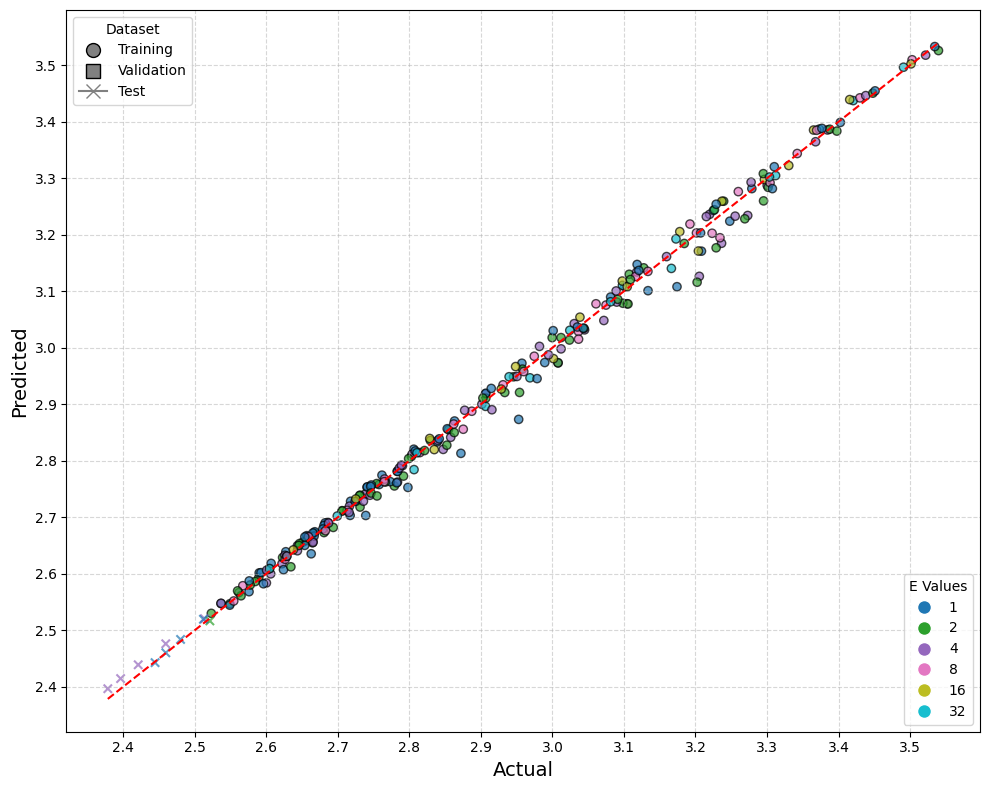

res['train_score']=0.0062191017711302
res['test_score']=0.0039154743652981


In [23]:
predicted_loss = predict_loss_joined(N=N, D=D, E=E, **res)
test_predicted_loss = predict_loss_joined(N=N_test, D=D_test, E=E_test, **res)
plot_pred_vs_actual(L, predicted_loss, L_test=L_test, L_test_pred=test_predicted_loss, E_train=E, E_test=E_test, in_log=False)
print(f"{res['train_score']=}")
print(f"{res['test_score']=}")

In [24]:
# @title
import numpy as np
import pandas as pd
import torch

def list_top_errors_train_test(
    N_train, D_train, E_train, L_train, L_pred_train,
    N_test, D_test, E_test, L_test, L_pred_test,
    top_n=10
):
    """
    Lists the top N biggest errors for both training and test datasets.

    Parameters:
    - N_train (array-like or torch.Tensor): Identifier for training samples.
    - D_train (array-like or torch.Tensor): Feature D for training samples.
    - E_train (array-like or torch.Tensor): Feature E for training samples.
    - L_train (array-like or torch.Tensor): Actual loss values for training samples.
    - L_pred_train (array-like or torch.Tensor): Predicted loss values for training samples.
    - N_test (array-like or torch.Tensor): Identifier for test samples.
    - D_test (array-like or torch.Tensor): Feature D for test samples.
    - E_test (array-like or torch.Tensor): Feature E for test samples.
    - L_test (array-like or torch.Tensor): Actual loss values for test samples.
    - L_pred_test (array-like or torch.Tensor): Predicted loss values for test samples.
    - top_n (int, default=10): Number of top errors to display.

    Outputs:
    - Prints two tables showing the top N errors for training and test sets respectively.
    """

    # Helper function to convert data to numpy arrays
    def to_numpy(data):
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        elif isinstance(data, list):
            return np.array(data)
        else:
            return np.array(data)

    # Convert all inputs to numpy arrays
    N_train = to_numpy(N_train)
    D_train = to_numpy(D_train)
    E_train = to_numpy(E_train)
    L_train = to_numpy(L_train)
    L_pred_train = to_numpy(L_pred_train)

    N_test = to_numpy(N_test)
    D_test = to_numpy(D_test)
    E_test = to_numpy(E_test)
    L_test = to_numpy(L_test)
    L_pred_test = to_numpy(L_pred_test)

    # Compute absolute errors
    errors_train = np.abs(L_train - L_pred_train)
    errors_test = np.abs(L_test - L_pred_test)

    # Create DataFrames for train and test
    df_train = pd.DataFrame({
        'N': N_train,
        'D': D_train,
        'E': E_train,
        'D/N': D_train/N_train,
        'Actual L': L_train,
        'Predicted L': L_pred_train,
        'Error': errors_train
    })

    df_test = pd.DataFrame({
        'N': N_test,
        'D': D_test,
        'E': E_test,
        'D/N': D_test/N_test,
        'Actual L': L_test,
        'Predicted L': L_pred_test,
        'Error': errors_test
    })

    # Sort DataFrames by error descendingly and take top_n
    top_errors_train = df_train.sort_values(by='Error', ascending=False).head(top_n)
    top_errors_test = df_test.sort_values(by='Error', ascending=False).head(top_n)

    # Display the results
    print("\n=== Top {} Biggest Errors in Training Set ===".format(top_n))
    print(top_errors_train.to_string(index=False))

    print("\n=== Top {} Biggest Errors in Test Set ===".format(top_n))
    print(top_errors_test.to_string(index=False))
list_top_errors_train_test(
    N_train=N,
    D_train=D,
    E_train=E,
    L_train=L,
    L_pred_train=predicted_loss,
    N_test=N_test,
    D_test=D_test,
    E_test=E_test,
    L_test=L_test,
    L_pred_test=test_predicted_loss,
    top_n=10  # Specify the number of top errors to display
)



=== Top 10 Biggest Errors in Training Set ===
           N            D   E      D/N  Actual L  Predicted L    Error
1103142144.0  499974144.0 2.0 0.453227  3.202312     3.115967 0.086345
2715922944.0  979959808.0 1.0 0.360820  2.952890     2.873245 0.079645
1103142144.0  499974144.0 4.0 0.453227  3.205401     3.126392 0.079010
1103142144.0  499974144.0 1.0 0.453227  3.174182     3.108062 0.066120
2715922944.0 1379991552.0 1.0 0.508111  2.872153     2.813163 0.058991
 682736384.0  499974144.0 2.0 0.732309  3.228889     3.176905 0.051983
 682736384.0  499974144.0 4.0 0.732309  3.236487     3.184904 0.051583
2715922944.0 1994981376.0 1.0 0.734550  2.798069     2.752837 0.045232
 469445120.0  499974144.0 2.0 1.065032  3.268977     3.228228 0.040750
 682736384.0  499974144.0 8.0 0.732309  3.234243     3.194704 0.039539

=== Top 10 Biggest Errors in Test Set ===
           N            D   E       D/N  Actual L  Predicted L    Error
1103142144.0 6.399990e+10 4.0 58.016006  2.396456     2.4

#### Bias in terms of E

##### Code

In [25]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

def analyse_e_bias():
    df = pd.DataFrame({'N': N, 'D': D, 'E': E, 'L': L, 'L_pred': predicted_loss})
    # remove smallest N < 60M
    #df = df[df['N'] > 6e7]

    df.loc[:, 'residual'] = df['L'] - df['L_pred']
    df.loc[:, 'residual_log'] = np.log(df['L']) - np.log(df['L_pred'])
    gdf = df.groupby('E')
    gdf = gdf.mean('residual')
    print(gdf)
    # Plotting a bar plot for residual_log values for each E
    plt.figure(figsize=(8, 5))
    gdf['residual_log'].plot(kind='bar', color='skyblue', edgecolor='black')

    # Adding labels and title
    plt.title("Residual Log Bias for Each E")
    plt.xlabel("E")
    plt.ylabel("Residual Log")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()


# Function to format large numbers (N, D) into human-readable format
def human_format(x, pos):
    if x >= 1e9:
        return f'{x*1e-9:.1f}B'
    elif x >= 1e6:
        return f'{x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x*1e-3:.1f}K'
    else:
        return str(x)

def analyse_bias_heatmaps():
    # Create a DataFrame with N, D, E, L, L_pred
    df = pd.DataFrame({'N': N, 'D': D, 'E': E, 'L': L, 'L_pred': predicted_loss})
    df.loc[:, 'residual'] = df['L'] - df['L_pred']
    df.loc[:, 'residual_log'] = np.log(df['L']) - np.log(df['L_pred'])

    # Group by N and E, by D and E, and by N and D, calculating the mean for residual_log
    gdf_n_e = df.groupby(['N', 'E']).mean('residual_log').reset_index()
    gdf_d_e = df.groupby(['D', 'E']).mean('residual_log').reset_index()
    gdf_n_d = df.groupby(['N', 'D']).mean('residual_log').reset_index()

    # Pivot the tables for heatmaps
    pivot_table_n_e = gdf_n_e.pivot(index='N', columns='E', values='residual_log')
    pivot_table_d_e = gdf_d_e.pivot(index='D', columns='E', values='residual_log')
    pivot_table_n_d = gdf_n_d.pivot(index='N', columns='D', values='residual_log')

    # Set up the figure and axes for side-by-side plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))


    # Determine maximum absolute value in the DataFrame to scale symmetrically
    pivot_tables = [
        pivot_table_n_e.to_numpy(),
        pivot_table_d_e.to_numpy(),
        pivot_table_n_d.to_numpy()
    ]

    max_abs_value = max(np.nanmax(np.abs(arr[np.isfinite(arr)])) for arr in pivot_tables)

    # Plot the N vs E heatmap
    sns.heatmap(pivot_table_n_e, annot=True, fmt=".4f", cmap='bwr', ax=ax1, cbar_kws={'label': 'Residual Log Bias'}, center=0, vmin=-max_abs_value, vmax=max_abs_value)
    ax1.set_title("Residual Log Bias Heatmap: N (Parameters) vs E (Expansion Rate)")
    ax1.set_xlabel("E (Expansion Rate)")
    ax1.set_ylabel("N (Parameters)")

    # Format N axis with human-readable format
    n_values = pivot_table_n_e.index
    ax1.set_yticks(np.arange(len(n_values)) + 0.5)
    ax1.set_yticklabels([human_format(n, None) for n in n_values])

    # Plot the D vs E heatmap
    sns.heatmap(pivot_table_d_e, annot=True, fmt=".4f", cmap='bwr', ax=ax2, cbar_kws={'label': 'Residual Log Bias'}, center=0, vmin=-max_abs_value, vmax=max_abs_value)
    ax2.set_title("Residual Log Bias Heatmap: D (Training Tokens) vs E (Expansion Rate)")
    ax2.set_xlabel("E (Expansion Rate)")
    ax2.set_ylabel("D (Training Tokens)")

    # Format D axis with human-readable format
    d_values = pivot_table_d_e.index
    ax2.set_yticks(np.arange(len(d_values)) + 0.5)
    ax2.set_yticklabels([human_format(d, None) for d in d_values])

    # Plot the N vs D heatmap
    sns.heatmap(pivot_table_n_d, annot=True, fmt=".4f", cmap='bwr', ax=ax3, cbar_kws={'label': 'Residual Log Bias'}, center=0, vmin=-max_abs_value, vmax=max_abs_value)
    ax3.set_title("Residual Log Bias Heatmap: N (Parameters) vs D (Training Tokens)")
    ax3.set_ylabel("N (Parameters)")
    ax3.set_xlabel("D (Training Tokens)")

    # Format N axis with human-readable format for the third plot
    n_values_nd = pivot_table_n_d.index
    ax3.set_yticks(np.arange(len(n_values_nd)) + 0.5)
    ax3.set_yticklabels([human_format(n, None) for n in n_values_nd])

    # Format D axis with human-readable format for the third plot
    d_values_nd = pivot_table_n_d.columns
    ax3.set_xticks(np.arange(len(d_values_nd)) + 0.5)
    ax3.set_xticklabels([human_format(d, None) for d in d_values_nd], rotation=45)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

##### Plots

                N             D         L    L_pred  residual  residual_log
E                                                                          
1.0   875067456.0  6.793466e+09  2.870867  2.867982  0.002886      0.000953
2.0   627726592.0  7.233589e+09  2.897181  2.892111  0.005070      0.001640
4.0   532642208.0  6.258524e+09  2.926286  2.921530  0.004756      0.001564
8.0   330788128.0  4.921197e+09  3.008176  3.007709  0.000466      0.000173
16.0  193261312.0  3.222194e+09  3.092995  3.098443 -0.005449     -0.001705
32.0  193261312.0  3.222194e+09  3.077985  3.079346 -0.001361     -0.000338


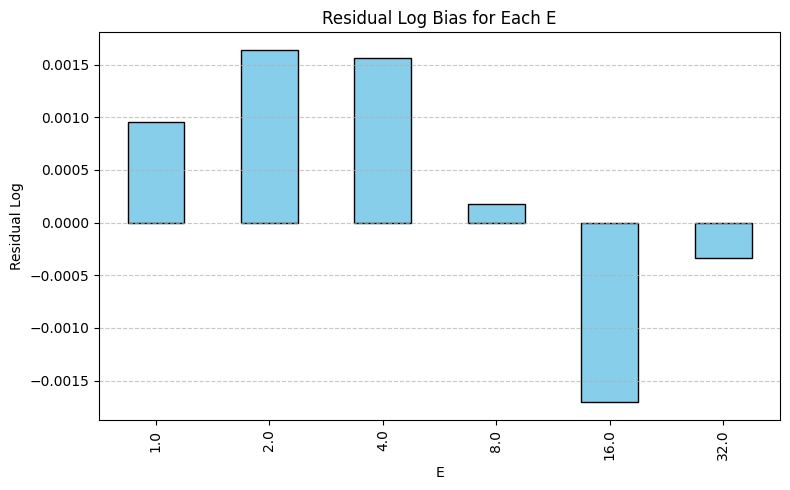

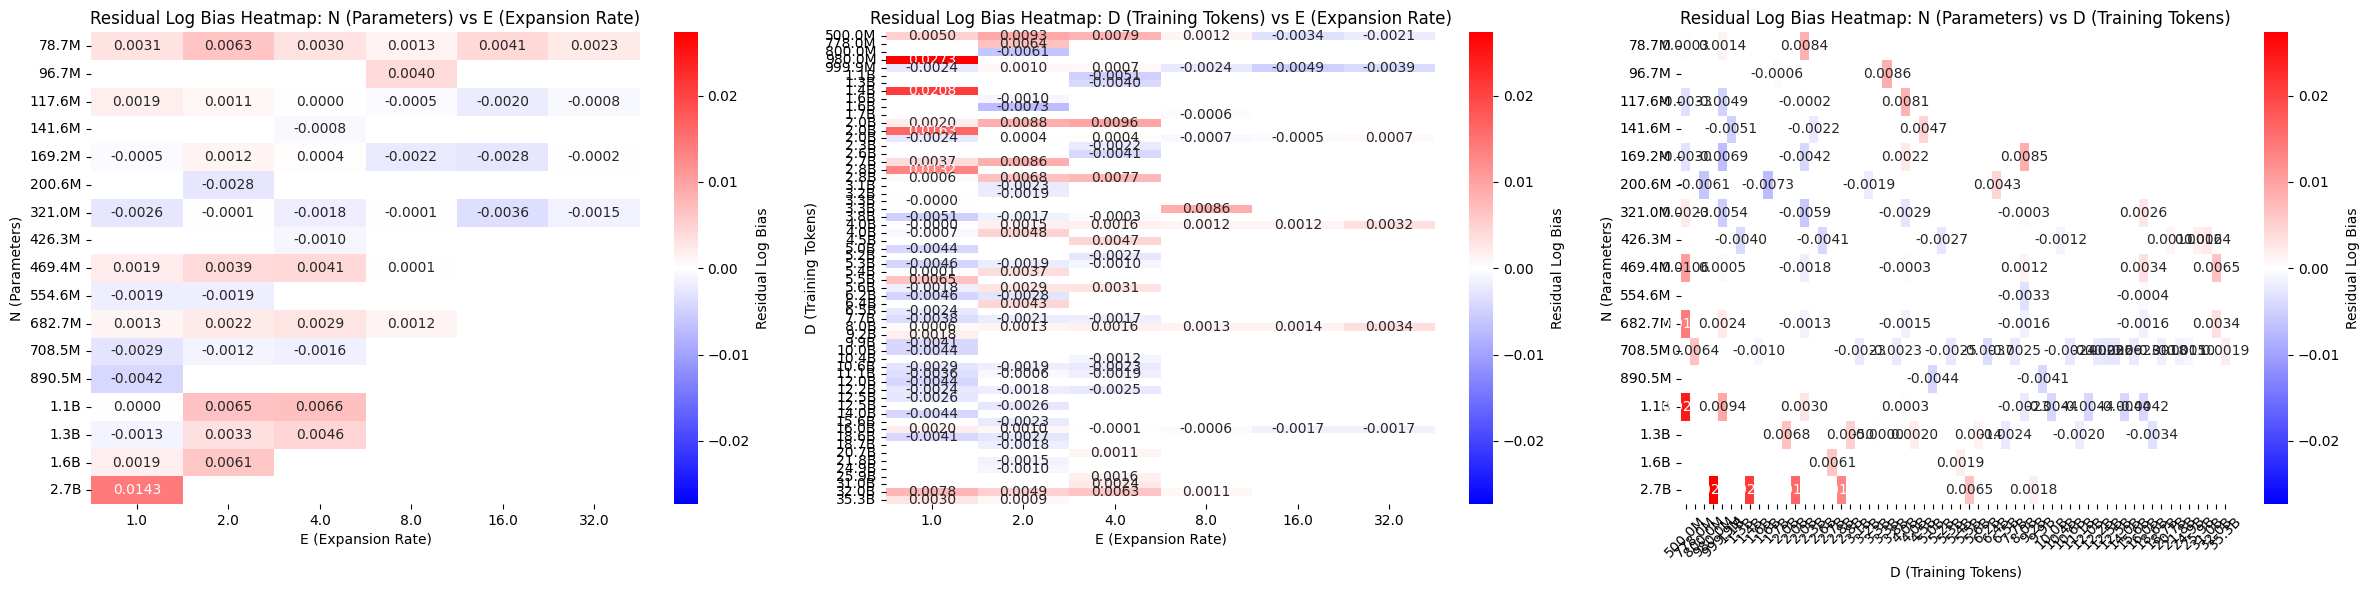

In [26]:
analyse_e_bias()
analyse_bias_heatmaps()

#### Coefficients in terms of E

In [27]:
def generate_separate_chinchillas_grid(E_range=(1,2,4,8,16,32), **params):
  return {e: project_joined_to_chinchilla(E=torch.tensor(e), **params) for e in E_range}

chinchillas_from_joined = generate_separate_chinchillas_grid(**res)
df_w = pd.DataFrame.from_dict(chinchillas_from_joined, orient='index', columns=chinchillas_from_joined[list(chinchillas_from_joined.keys())[0]].keys())

similarity = predict_loss(**chinchillas_from_joined[4], N=1e8, D=1e10), predict_loss_joined(E=4, **res, N=1e8, D=1e10)
assert np.allclose(similarity[0], similarity[1])

df_w

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {k: torch.tensor(v) if isinstance(v, np.generic) or isinstance(v, np.ndarray) or isinstance(v, float) or isinstance(v, int)  else v for k, v in args.items()}
<ipython-input-13-60a104f17ca9>:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {k: torch.tensor(v) if isinstance(v, np.generic) or isinstance(v, np.ndarray) or isinstance(v, float) or isinstance(v, int)  else v for k, v in args.items()}


,A,B,C,alpha,beta
1,30.363993648167263,53.98384414155987,1.3637398258736753,0.18173956204827252,0.19650191228646036
2,27.79821195271775,66.84011296802187,1.3637398258736753,0.17795397781692185,0.20648914813917155
4,24.846202931338134,87.70219698814259,1.3637398258736753,0.17314011944591995,0.21918920603633535
8,21.832989774298056,119.91258457347162,1.3637398258736753,0.1675966335114486,0.23381418809729415
16,19.015896366339852,167.50725788774776,1.3637398258736753,0.16167306968397718,0.24944190245208414
32,16.54244596529427,234.67256254388218,1.3637398258736753,0.1556980993088928,0.2652052390210445


#### Optimal D/N ratio

In [28]:
N_values = np.array([100e6, 1e9, 3e9, 7e9, 70e9, 400e9])

for e, row in chinchillas_from_joined.items():
  print(f"For {e=}")
  print_compute_optimal_configs_for_N(N_values, E=e, **res, single_chinchilla_params=chinchillas_from_joined[e], with_embeddings=data_filters["with_embeddings"])


#flops_budgets = np.array([1.192473e+18, 1.809944e+18, 2.758660e+18, 4.222465e+18, 6.490638e+18, 1.002030e+19])
flops_budgets = np.array([1e18, 1e19, 1e20, 1e21, 1e22, 1e23])

for e, row in chinchillas_from_joined.items():
  print(f"For {e=}")
  print_compute_optimal_configs_for_flops(flops_budgets, E=e, single_chinchilla_params=chinchillas_from_joined[e], **res, with_embeddings=data_filters["with_embeddings"])


def compute_opt_D_for_N_with_embeddings(N_with_emb, e):
  return get_optimal_D_for_N_with_embeddings(N_with_emb, single_chinchilla_params=chinchillas_from_joined[e], **res, with_embeddings=True)

print(f"{compute_opt_D_for_N_with_embeddings(1e9, 4)=}")
print(f"{compute_opt_D_for_N_with_embeddings(1e9, 1)=}")

For e=1
Optimal for N (with embeddings) 100.00M : D: 697.45M D/N: 6.97448 
Optimal for N (with embeddings) 1.00B   : D: 5.87B   D/N: 5.86585 
Optimal for N (with embeddings) 3.00B   : D: 16.20B  D/N: 5.4015  
Optimal for N (with embeddings) 7.00B   : D: 35.47B  D/N: 5.06653 
Optimal for N (with embeddings) 70.00B  : D: 298.28B D/N: 4.26118 
Optimal for N (with embeddings) 400.00B : D: 1.49T   D/N: 3.73727 
For e=2
Optimal for N (with embeddings) 100.00M : D: 1.13B   D/N: 11.2838 
Optimal for N (with embeddings) 1.00B   : D: 8.21B   D/N: 8.21134 
Optimal for N (with embeddings) 3.00B   : D: 21.16B  D/N: 7.05252 
Optimal for N (with embeddings) 7.00B   : D: 43.93B  D/N: 6.275   
Optimal for N (with embeddings) 70.00B  : D: 319.35B D/N: 4.56217 
Optimal for N (with embeddings) 400.00B : D: 1.44T   D/N: 3.58772 
For e=4
Optimal for N (with embeddings) 100.00M : D: 1.93B   D/N: 19.2988 
Optimal for N (with embeddings) 1.00B   : D: 11.90B  D/N: 11.8975 
Optimal for N (with embeddings) 3.00B 

## Plots


#### Validation plots

In [29]:
# @title
import torch
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Get unique D values
unique_D_values = torch.unique(D).flip(dims=(0,))
num_plots = len(unique_D_values)

# Golden ratio aspect (1:1.618)
golden_ratio = 1.2

# Set number of columns to 2
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows to accommodate all subplots

# Create subplots with 2 columns
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    shared_xaxes=True,
    subplot_titles=[f'D = {present_v(d.item())}' for d in unique_D_values],
    vertical_spacing=0.05,  # Reduce vertical spacing
    horizontal_spacing=0.05  # Reduce horizontal spacing
)

# Loop through each unique D value to create individual subplots
for i, d_value in enumerate(unique_D_values):
    # Select points where D is equal to the current d_value
    mask = (D == d_value)
    E_filtered = E[mask]
    L_filtered = L[mask]
    N_filtered = N[mask]

    # Create scatter plot for the filtered values (actual L values)
    scatter_actual = go.Scatter(x=E_filtered.numpy(), y=L_filtered.numpy(), mode='markers', name=f'Actual L (D = {present_v(d_value.item())})',marker=dict(size=7))
    # version with bigger dots:


    # Determine row and col positions dynamically
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    # Add actual data trace to the subplot
    fig.add_trace(scatter_actual, row=row, col=col)

    # Get unique N values for the current D
    unique_N_values = torch.unique(N_filtered)

    # Generate predicted loss lines for each unique N
    for n_value in unique_N_values:
        # Generate a range of E values for prediction
        E_range = np.logspace(np.log10(E_filtered.min()), np.log10(E_filtered.max()), num=100)

        # Calculate predicted L values
        L_predicted = [predict_loss_joined(E=e, **res, N=n_value.item(), D=d_value.item()) for e in E_range]

        # Create scatter plot for predicted values (without adding to legend)
        scatter_predicted = go.Scatter(x=E_range, y=L_predicted, mode='lines', line=dict(dash='dot'),
                                       showlegend=False)

        # Add predicted data trace to the subplot
        fig.add_trace(scatter_predicted, row=row, col=col)

# Update layout for golden ratio
fig.update_layout(
    height=400 * num_rows,  # Adjust height for each row
    width=400 * num_cols * golden_ratio,  # Adjust width based on golden ratio
    title_text="Loss L vs E with Predicted Loss for different D values",
    showlegend=True
)
# hardcoded
#min = np.log10(2.7)
#max = np.log10(6.3)
# auto
min_v = np.log10(L.min() - 0.1)
max_v = np.log10(L.max() + 0.1)

# Update axes for log scale and set y-limits
fig.update_xaxes(title_text="E", type="log")
fig.update_yaxes(title_text="L", type="log", range=[min_v, max_v])  # Set y-limits here


# set proper ticks for E : 1,2,4,8,16,32
fig.update_xaxes(tickvals=[1, 2, 4, 8, 16, 32], ticktext=['1', '2', '4', '8', '16', '32'])
# Show the plot
fig.show()

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



In [30]:
# @title
import torch
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
from plotly.colors import qualitative

def present_ratio(d, n):
    r = d/n if not data_filters["tokens_counted_per_active"] else d
    return f"{r:.3g}"  # 3 significant digits

def is_pareto_point(x, y, points):
    """
    Determines if a point (x, y) is on the Pareto curve.
    A point is not Pareto-optimal if there exist two other points (x1, y1) and (x2, y2)
    such that the line between (x1, y1) and (x2, y2) lies below (x, y).
    """
    for i, (x1, y1) in enumerate(points):
        for j, (x2, y2) in enumerate(points):
            if i >= j:  # Avoid duplicate or reverse comparisons
                continue
            # Skip if the test line cannot bracket the current x value
            if not (min(x1, x2) < x < max(x1, x2)):
                continue
            # Linear interpolation to check if the line lies below the point
            y_line = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
            if y_line < y:
                return False
    return True

# Define unique E values
unique_E_values = torch.unique(E)
num_plots = len(unique_E_values)

# Set the layout of subplots (e.g., 2 columns)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows to fit all subplots

# Create subplots
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    subplot_titles=[f'E = {e.item()}' for e in unique_E_values],
    shared_xaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05
)

# Define a distinct color palette for N values
color_palette = qualitative.Set2  # Use Plotly's Set2 palette for clear distinctions

# Loop over each unique E value
for i, e_value in enumerate(unique_E_values):
    # Filter data for the current E value
    mask_E = (E == e_value)
    N_filtered = N[mask_E]
    L_filtered = L[mask_E]
    D_filtered = D[mask_E]

    # Determine subplot row and column
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    # Combine points for Pareto check
    points = 6 * N_filtered * D_filtered if not data_filters["tokens_counted_per_active"] else 6 * N_filtered * D_filtered * N_filtered
    points = list(zip((points).numpy(), L_filtered.numpy()))

    # Loop over unique N values for points and predicted curves
    unique_N_values = torch.unique(N_filtered)
    for j, n_value in enumerate(unique_N_values):
        # Use a color from the palette, cycling if needed
        color = color_palette[j % len(color_palette)]

        # Mask data for the current N value
        mask_N = (N_filtered == n_value)
        D_current = D_filtered[mask_N]
        L_current = L_filtered[mask_N]

        if data_filters["tokens_counted_per_active"]:
          FLOPS_current = (6 * n_value.item() * D_current * n_value.item()).numpy()
        else:
          FLOPS_current = (6 * n_value.item() * D_current).numpy()


        # Identify Pareto points
        labels = [
            present_ratio(D, n_value.item()) if is_pareto_point(f, l, points) else ""
            for f, l, D in zip(FLOPS_current, L_current.numpy(), D_current)
        ]

        # Add actual data points
        scatter_actual = go.Scatter(
            x=FLOPS_current,
            y=L_current.numpy(),
            text=labels,
            textfont=dict(size=10, color=f'rgba({color[4:-1]}, 0.7)'),  # Match color with alpha
            mode='markers+text',
            textposition="bottom center",
            name=f'Actual {present_v(n_value.item())} (E={e_value.item()})',
            marker=dict(size=8, color=color),
            legendgroup=f'{n_value.item()}',
            showlegend=(row == 1 and col == 1)  # Only show legend once
        )
        fig.add_trace(scatter_actual, row=row, col=col)

        # Generate predicted loss for interpolated D
        D_range = np.logspace(np.log10(D.min()), np.log10(D.max()), num=100)
        L_predicted = [
            predict_loss_joined(E=e_value.item(), **res, N=n_value.item(), D=d)
            for d in D_range
        ]

        if data_filters["tokens_counted_per_active"]:
          #FLOPS_current = (6 * n_value.item() * D_current * n_value.item()).numpy()
          FLOPS_predicted = (6 * n_value.item() * D_range* n_value.item())
        else:
          FLOPS_predicted = (6 * n_value.item() * D_range)

        # Add predicted loss curve
        scatter_predicted = go.Scatter(
            x=FLOPS_predicted,
            y=L_predicted,
            mode='lines',
            line=dict(color=color, dash='dot'),
            name=f'Predicted {present_v(n_value.item())} (E={e_value.item()})',
            legendgroup=f'{n_value.item()}',
            showlegend=False
        )
        fig.add_trace(scatter_predicted, row=row, col=col)

# Update layout
fig.update_layout(
    title_text="Loss (L) vs FLOPS for Different E Values (Pareto-Filtered Labels)",
    xaxis_title="FLOPS (log scale)",
    yaxis_title="Loss (L)",
    showlegend=True,
    height=400 * num_rows,
    width=800 * num_cols
)

# Update axes for log scale
fig.update_xaxes(title_text="FLOPS", type="log")
fig.update_yaxes(title_text="Loss (L)", type="log")

# Show plot
fig.show()

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



In [31]:
# @title
import torch
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Get unique N values
unique_N_values = torch.unique(N).flip(dims=(0,))
num_plots = len(unique_N_values)

# Golden ratio aspect (1:1.618)
golden_ratio = 1.2

# Set number of columns to 4
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows to accommodate all subplots

# Create subplots with increased vertical spacing
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    shared_xaxes=True,
    subplot_titles=[f'N = {present_v(n.item())}' for n in unique_N_values],
    vertical_spacing=0.15,  # Increase vertical spacing
    horizontal_spacing=0.05  # Keep horizontal spacing as before
)

D_names = set()

# Loop through each unique N value to create individual subplots
for i, n_value in enumerate(unique_N_values):
    # Select points where N is equal to the current n_value
    mask = (N == n_value)
    E_filtered = E[mask]
    L_filtered = L[mask]
    D_filtered = D[mask]

    # Create scatter plot for the filtered values (actual L values)
    scatter_actual = go.Scatter(
        x=E_filtered.numpy(),
        y=L_filtered.numpy(),
        mode='markers',
        name=f'Actual L (N = {present_v(n_value.item())})',
        marker=dict(size=7)
    )

    # Determine row and col positions dynamically
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    # Add actual data trace to the subplot
    fig.add_trace(scatter_actual, row=row, col=col)

    # Get unique D values for the current N
    unique_D_values = torch.unique(D_filtered)

    # Generate predicted loss lines for each unique D
    for d_value in unique_D_values:
        # Generate a range of E values for prediction
        E_range = np.logspace(np.log10(E_filtered.min()), np.log10(E_filtered.max()), num=100)

        # Calculate predicted L values
        L_predicted = [predict_loss_joined(E=e, **res, N=n_value.item(), D=d_value.item()) for e in E_range]

        name = f'D = {present_v(d_value.item())}'

        # Create scatter plot for predicted values (without adding to legend)
        scatter_predicted = go.Scatter(
            x=E_range,
            y=L_predicted,
            mode='lines',
            name=name,
            line=dict(dash='dot'),
            showlegend=name not in D_names
        )

        D_names.add(name)

        # Add predicted data trace to the subplot
        fig.add_trace(scatter_predicted, row=row, col=col)

# Update layout for golden ratio
fig.update_layout(
    height=450 * num_rows,  # Adjust height for each row
    width=400 * num_cols * golden_ratio,  # Adjust width based on golden ratio
    title_text="Loss L vs E with Predicted Loss for different N values",
    showlegend=True
)

# Auto calculate min and max values for the y-axis
min_v = np.log10(L.min() - 0.1)
max_v = np.log10(L.max() + 0.1)

# Update axes for log scale and set y-limits
fig.update_xaxes(title_text="E", type="log")
fig.update_yaxes(title_text="L", type="log", range=[min_v, max_v])  # Set y-limits here

# Set proper ticks for E : 1,2,4,8,16,32
fig.update_xaxes(tickvals=[1, 2, 4, 8, 16, 32], ticktext=['1', '2', '4', '8', '16', '32'])

# Show the plot
fig.show()

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



#### Memory constrained plots jkrajewski

###### Code for plot

In [32]:
def plot_for_memory_constraint(
    predict_loss: callable,
    memory_constraint: int,
    get_total_from_active: callable,
    get_active_from_total: callable,
    min_train_flop_budget=1e18,
    max_train_flop_budget=5e21,
    N_active_from_exps=None,
    D_from_exps=None,
    E_from_exps=None,
    L_from_exps=None,
    inference_tokens=None
):
    import numpy as np
    import plotly.graph_objects as go
    from plotly.colors import qualitative

    if N_active_from_exps is not None:
      N_total_from_exps = get_total_from_active(N_active_from_exps, E_from_exps)

      points_to_plot_mask = (np.abs((N_total_from_exps - memory_constraint)) / memory_constraint) < 0.1
      # points_to_plot_mask = (np.abs(np.log(N_total_from_exps) - np.log(memory_constraint)) / np.log(memory_constraint)) < 0.005
      N_active_from_exps = N_active_from_exps[points_to_plot_mask]
      D_from_exps = D_from_exps[points_to_plot_mask]
      E_from_exps = E_from_exps[points_to_plot_mask]
      L_from_exps = L_from_exps[points_to_plot_mask]

    palette = qualitative.Dark24_r

    flops_range = np.logspace(
        np.log10(min_train_flop_budget),
        np.log10(max_train_flop_budget),
        30
    )

    expansion_rates = [1, 2, 4, 8, 16, 32]
    fig = go.Figure()

    for i, E in enumerate(expansion_rates):
        color = color_palette[i % len(color_palette)] if E != 32 else 'darkorange'

        plot_mask = E_from_exps == E
        budgets = 6 * N_active_from_exps[plot_mask] * D_from_exps[plot_mask]
        if inference_tokens is not None:
          budgets += 6 * N_active_from_exps[plot_mask] * inference_tokens
        losses = L_from_exps[plot_mask]

        fig.add_trace(
            go.Scatter(
                x=budgets,
                y=losses,
                mode='markers',
                name=f'E={E}',
                marker=dict(color=color)
            )
        )

        budgets=np.logspace(np.log10(min_train_flop_budget), np.log10(max_train_flop_budget), num=1000)
        active_params=np.repeat(get_active_from_total(memory_constraint, E), len(budgets))
        D = budgets / (6 * active_params)
        losses = predict_loss(active_params, D, np.repeat(E, len(active_params)))

        fig.add_trace(
            go.Scatter(
                x=budgets,
                y=losses,
                mode='lines',
                name=f'E={E}',
                line=dict(color=color)
            )
        )


    compute_opt_for_dense=6*5*memory_constraint**2
    fig.add_vline(
        x=compute_opt_for_dense, # compute optimal for dense
        line_width=2,
        line_dash="dash",
        line_color=color_palette[0],
    )


    fig.update_layout(
        xaxis=dict(type='log', title='Training FLOPs'),
        yaxis=dict(type='log', title='Predicted Loss'),
        height=900,
        width=1200,
        title=f"Scaling Curves for Models with {format_large_numbers(memory_constraint)} Total Params"
    )
    fig.add_annotation(
        x=0.01,
        y=0.01,                # you can adjust this
        xref="paper",
        yref="paper",
        text="Dashed:\nCompute optimal for dense",
        showarrow=False,
        font=dict(
        size=20,          # Increased font size from 12 to 16
        color=color_palette[0],
        family="Arial"    # Optional: Specify a font family
    ),
    )
    fig.show()

##### Actual plot

In [33]:
plot_for_memory_constraint(
    predict_loss=lambda N, D, E: predict_loss_joined(N=N, D=D, E=E, **res),
    # memory_constraint=0.6e09,
    memory_constraint=1e09,
    get_total_from_active=lambda N, E : N * (9*E+4)/13,
    get_active_from_total=lambda N, E : N * 13/(9*E+4),
    # max_train_flop_budget=5e25,
    min_train_flop_budget=5e16,
    N_active_from_exps=N,
    D_from_exps=D,
    E_from_exps=E,
    L_from_exps=L,
)

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



#### Estimating optimal token to param ratio using Chinchilla Approach 2

In [34]:
def get_total_params(
    n_layers: int,
    dmodel: int,
    expert_hidden_size: int,
    n_experts: int,
    vocab_size: int = 50257,
    with_embeddings: bool = False
):
    # -- 1) Att per layer (simplified: 4*dmodel^2).
    attention_params_per_layer = 4 * (dmodel ** 2)

    # -- 2) MoE feed-forward for all experts in one layer:
    ff_moe_params_per_layer = n_experts * (3 * dmodel * expert_hidden_size)

    # -- 3) Gating network per layer: (dmodel -> n_experts)
    gating_params_per_layer = (dmodel * n_experts)

    # Sum for one layer
    layer_params = attention_params_per_layer + ff_moe_params_per_layer + gating_params_per_layer

    # Multiply by number of layers
    transformer_params = n_layers * layer_params

    # -- 4) Embeddings (input + output)
    embedding_params = 2 * vocab_size * dmodel

    # Total
    total_params = transformer_params

    if with_embeddings:
      total_params += embedding_params

    return total_params


def get_active_params(
    n_layers: int,
    dmodel: int,
    expert_hidden_size: int,
    n_experts: int,
    vocab_size: int = 50257,
    with_embeddings: bool = False
):
    # -- 1) MHA per layer (same as total, because all attention heads/layers are used)
    attention_params_per_layer = 4 * (dmodel ** 2)

    # -- 2) Gating network per layer: we must compute gating for all experts
    gating_params_per_layer = (dmodel * n_experts)

    # -- 3) Only 1 expert is active per layer (top-1 gating):
    ff_moe_params_per_layer = 3 * dmodel * expert_hidden_size

    layer_params = attention_params_per_layer + gating_params_per_layer + ff_moe_params_per_layer
    transformer_params = n_layers * layer_params

    # -- 4) Embeddings (input + output).
    embedding_params = 2 * vocab_size * dmodel

    active_params = transformer_params

    if with_embeddings:
      active_params += embedding_params

    return active_params

In [35]:
table = get_full_table(raw_table, "constrained_scaling_grid_21_11")

Number of experiments: 719
All sizes and token counts in table:
['2.9B' '736.1M' '3.0B' '955.5M' '959.5M' '935.9M' '2.4B' '1.2B' '1.7B'
 '567.0M' '3.6B' '2.0B' '4.2B' '2.5B' '720.9M' '1.4B' '426.0M' '226.9M'
 '218.1M' '258.3M' '198.0M' '207.9M' '340.8M' '3.9B' '1.0B' '576.7M'
 '3.2B' '915.9M' '541.2M' '1.6B' '2.1B' '671.1M' '4.9B' '369.1M' '606.2M'
 '537.9M' '1.3B' '283.1M' '155.7M' '92.0M' '311.3M' '163.8M' '90.1M'
 '53.2M' '76.5M' '38.8M' '19.9M' '10.5M' '5.8M' '3.4M' '159.4M' '83.9M'
 '612.4M' '46.1M' '310.4M' '27.3M' '44.8M' '23.6M' '172.2M' '13.0M'
 '87.3M' '7.7M']
['15.8B' '9.9B' '5.0B' '45.4B' '38.5B' '25.7B' '36.2B' '31.0B' '25.9B'
 '21.8B' '18.7B' '15.6B' '14.0B' '12.0B' '10.0B' '31.7B' '23.7B' '5.4B'
 '2.7B' '6.5B' '3.3B' '35.3B' '12.2B' '10.6B' '7.7B' '5.3B' '3.8B' '18.6B'
 '11.1B' '5.6B' '4.0B' '2.8B' '2.0B' '9.2B' '5.5B' '1.4B' '980.0M' '16.0B'
 '8.0B' '12.5B' '6.2B' '500.0M' '371.8B' '318.7B' '265.6B' '212.4B'
 '159.3B' '106.2B' '53.1B' '26.6B' '13.3B' '6.6B' '1.7B' '253.

In [36]:
p_table = pd.DataFrame()
p_table["n_layers"] = table["args/n_blocks"]
p_table["dmodel"] = table["args/dmodel"]
p_table["n_experts"] = table["args/n_experts"]
p_table["expert_hidden_size"] = 3 * table["args/dmodel"]
p_table["train_tokens"] = table["tokens"]
p_table["loss"] = table["loss_interval/100"]
p_table.columns

Index(['n_layers', 'dmodel', 'n_experts', 'expert_hidden_size', 'train_tokens',
       'loss'],
      dtype='object')

In [37]:
p_table["total_params"] = p_table.apply(
    lambda row: get_total_params(
        n_layers=row["n_layers"],
        dmodel=row["dmodel"],
        expert_hidden_size=row["expert_hidden_size"],
        n_experts=row["n_experts"],
    ),
    axis=1
)

p_table["active_params"] = p_table.apply(
    lambda row: get_active_params(
        n_layers=row["n_layers"],
        dmodel=row["dmodel"],
        expert_hidden_size=row["expert_hidden_size"],
        n_experts=row["n_experts"]
    ),
    axis=1
)

p_table["flops"] = 6 * p_table["active_params"] * p_table["train_tokens"]

In [38]:
def calc_num_exps(budget):
  e_rate = 1
  flop_budget = budget
  tol = 0.005

  table1 = p_table[p_table["n_experts"] == e_rate]
  table1 = table1.sort_values(by="flops")
  table1["tpr"] = table1["train_tokens"] / table1["total_params"]

  flop_min = np.exp((1-tol)*np.log(flop_budget))
  flop_max = np.exp((1+tol)*np.log(flop_budget))
  # print(f"{flop_min=:.2e},{flop_max=:.2e}")
  filtered_table = table1[table1["flops"] > flop_min]
  filtered_table = filtered_table[filtered_table["flops"] < flop_max]
  return len(filtered_table), filtered_table["flops"].min(), filtered_table["flops"].max(), flop_max

In [39]:
start_budget = 8.741692e+16
end_budget = 3.177170e+20

budgets_to_anaylyze = []
current_budget = start_budget
prev_max_found = current_budget

while current_budget < end_budget:
  num_exps, min_found, max_found, flop_max = calc_num_exps(current_budget)
  if num_exps >= 5 and min_found > prev_max_found:
    budgets_to_anaylyze.append(current_budget)
    prev_max_found = max_found
  current_budget = flop_max

budgets_to_analyze = budgets_to_anaylyze[1:-1]

In [40]:
def calculate_closest_budget(budget):
    closest_budget = min(budgets_to_analyze, key=lambda x: abs(x - budget))
    return closest_budget

def fit_parabola_and_find_min(group):
    # Log-transform the data
    x = np.log(group['train_tokens'])
    y = np.log(group['loss'])

    # Fit a quadratic function: y = a*x^2 + b*x + c
    coefficients = np.polyfit(x, y, deg=2)
    a, b, c = coefficients

    # Calculate the x-coordinate of the parabola's vertex (minimum point)
    x_min = -b / (2 * a)

    # Convert back to the original scale
    optimal_train_tokens = np.exp(x_min)

    # Calculate the predicted minimum loss
    min_loss_log = a * x_min**2 + b * x_min + c
    predicted_min_loss = np.exp(min_loss_log)

    # Return the results
    return pd.DataFrame({
        'budget_group': [group.name],
        'optimal_train_tokens': [optimal_train_tokens],
        'predicted_min_loss': [predicted_min_loss]
    })

In [41]:
e_rate = 1

p_table["budget_group"] = p_table["flops"].map(calculate_closest_budget)
budget_group_diff = np.abs(np.log(p_table["flops"]) - np.log(p_table["budget_group"]))
filtered_table = p_table[budget_group_diff < 0.2]
df = filtered_table[filtered_table["n_experts"] == e_rate]
flop_budgets = budgets_to_analyze[1:-1]
df["budget_group"] = df["flops"].map(calculate_closest_budget)

plot_width = 1200
plot_height = 800
fig = go.Figure()
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
color_map = {bg: colors[i % len(colors)] for i, bg in enumerate(flop_budgets)}

for bg in flop_budgets:
    df_bg = df[df['budget_group'] == bg].copy()
    x = df_bg['train_tokens']
    y = df_bg['loss']

    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=f'Budget Group {bg}',
        marker=dict(color=color_map[bg])
    ))

    # Fit a parabola
    log_x = np.log(x)
    log_y = np.log(y)
    coeffs = np.polyfit(log_x, log_y, 2)

    # Generate x values for the fit line in the actual value space
    x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
    log_x_fit = np.log(x_fit)
    log_y_fit = coeffs[0]*log_x_fit**2 + coeffs[1]*log_x_fit + coeffs[2]
    y_fit = np.exp(log_y_fit)

    # Plot the fitted parabola as a dashed line
    fig.add_trace(go.Scatter(
        x=x_fit,
        y=y_fit,
        mode='lines',
        showlegend=False,
        line=dict(dash='dash', color=color_map[bg])
    ))

fig.update_layout(
    title='IsoFLOP profiles',
    xaxis_title='Training Tokens',
    yaxis_title='Loss',
    legend_title='Budget Groups',
    template='plotly_white',
    width=plot_width,
    height=plot_height,
    xaxis_type='log',
    yaxis_type='log',
    xaxis=dict(
        tickformat='.1e',
    ),
    yaxis=dict(
        tickformat='.1e',
        range=[np.log10(y.min()-0.1), np.log10(3.3)],
        tickmode='linear',
        dtick=0.5
    )
)

fig.show()

<ipython-input-41-67960060f060>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
def optimal_tpr(e_rate):
  p_table["budget_group"] = p_table["flops"].map(calculate_closest_budget)
  budget_group_diff = np.abs(np.log(p_table["flops"]) - np.log(p_table["budget_group"]))
  filtered_table = p_table[budget_group_diff < 0.2]

  # Apply the function to each budget_group
  results = filtered_table[filtered_table["n_experts"] == e_rate].groupby('budget_group').apply(fit_parabola_and_find_min)

  # Reset index to flatten the DataFrame
  results = results.reset_index(drop=True)

  results["token_param_ratio"] = results["optimal_train_tokens"] / (results["budget_group"] / (6*results["optimal_train_tokens"]))
  return results["token_param_ratio"][:6].mean()

def list_optimal_tpr(e_rate):
  p_table["budget_group"] = p_table["flops"].map(calculate_closest_budget)
  budget_group_diff = np.abs(np.log(p_table["flops"]) - np.log(p_table["budget_group"]))
  filtered_table = p_table[budget_group_diff < 0.2]

  # Apply the function to each budget_group
  results = filtered_table[filtered_table["n_experts"] == e_rate].groupby('budget_group').apply(fit_parabola_and_find_min)

  # Reset index to flatten the DataFrame
  results = results.reset_index(drop=True)

  results["token_param_ratio"] = results["optimal_train_tokens"] / (results["budget_group"] / (6*results["optimal_train_tokens"]))
  return results["token_param_ratio"][:6]

list_optimal_tpr(1)

<ipython-input-42-402782b44cb6>:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,token_param_ratio
0,27.494944
1,37.696893
2,19.222535
3,26.831502
4,25.604526
5,6.459817


In [43]:
tprs = pd.DataFrame({"Expansion Rate": [1, 2, 4, 8, 16]})
tprs["Optimal Token to Active Param Ratio"] = tprs["Expansion Rate"].map(optimal_tpr)

tprs

<ipython-input-42-402782b44cb6>:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-42-402782b44cb6>:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-42-402782b44cb6>:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `i

,Expansion Rate,Optimal Token to Active Param Ratio
0,1,23.885036
1,2,32.708834
2,4,47.190953
3,8,57.145134
4,16,1499.135276


In [44]:
def get_compute_optimal_tpr(e_rate):
  return tprs[tprs["Expansion Rate"] == e_rate]["Optimal Token to Active Param Ratio"].iloc[0]

#### Memory constrained plots based on data (plot with buttons)

In [45]:
def render_with_buttons(options: list):
    frames = []
    params = []
    nums_experts = []

    # Build one frame per option
    for i, (dmodel1, n_experts1, dmodel2, n_experts2) in enumerate(options):
        # Filter data
        filtered_table_1 = p_table[(p_table["dmodel"] == dmodel1) & (p_table["n_experts"] == n_experts1)]
        filtered_table_2 = p_table[(p_table["dmodel"] == dmodel2) & (p_table["n_experts"] == n_experts2)]
        filtered_table = pd.concat([filtered_table_1, filtered_table_2])

        filtered_table["tokens_r"] = filtered_table["train_tokens"].map(format_large_numbers)
        filtered_table["active_r"] = filtered_table["active_params"].map(format_large_numbers)
        filtered_table = filtered_table.sort_values(by="flops")

        data_traces = []
        # Build traces for each unique n_experts in filtered data
        for n_exp in filtered_table["n_experts"].unique():
            sub_df = filtered_table[filtered_table["n_experts"] == n_exp]
            data_traces.append(
                go.Scatter(
                    x=sub_df["flops"],
                    y=sub_df["loss"],
                    mode="lines+markers",
                    name=f"n_experts={n_exp}",
                    text=[
                        f"tokens_r={x}; active_r={y}"
                        for x, y in zip(sub_df["tokens_r"], sub_df["active_r"])
                    ],
                )
            )

        # We'll create the vertical lines and place annotations near those lines
        annotations = []
        y_min, y_max = filtered_table["loss"].min(), filtered_table["loss"].max()

        # Vline + annotation for model 1
        if not filtered_table_1.empty:
            compute_opt_tpr_1 = get_compute_optimal_tpr(n_experts1)
            vline1_x = (
                filtered_table_1["active_params"].iloc[0]
                * compute_opt_tpr_1
                * filtered_table_1["active_params"].iloc[0]
                * 6
            )
            data_traces.append(
                go.Scatter(
                    x=[vline1_x, vline1_x],
                    y=[y_min, y_max],
                    mode="lines",
                    line=dict(dash="dash", color="blue"),
                    showlegend=False,
                )
            )
            # Position the annotation near the top of that line
            annotations.append(
                go.layout.Annotation(
                    x=vline1_x,
                    y=y_max,
                    xref="x",
                    yref="y",
                    text="Compute optimal for model 1",
                    showarrow=False,
                    font=dict(color="blue"),
                    xanchor="left",
                    yanchor="top",
                )
            )

        # Vline + annotation for model 2
        if not filtered_table_2.empty:
            compute_opt_tpr_2 = get_compute_optimal_tpr(n_experts2)
            vline2_x = (
                filtered_table_2["active_params"].iloc[0]
                * compute_opt_tpr_2
                * filtered_table_2["active_params"].iloc[0]
                * 6
            )
            data_traces.append(
                go.Scatter(
                    x=[vline2_x, vline2_x],
                    y=[y_min, y_max],
                    mode="lines",
                    line=dict(dash="dash", color="red"),
                    showlegend=False,
                )
            )
            # Position the annotation near the bottom of that line
            annotations.append(
                go.layout.Annotation(
                    x=vline2_x,
                    y=y_min,
                    xref="x",
                    yref="y",
                    text="Compute optimal for model 2",
                    showarrow=False,
                    font=dict(color="red"),
                    xanchor="left",
                    yanchor="bottom",
                )
            )

        # Create a frame with the data and layout (annotations)
        frames.append(
            go.Frame(
                data=data_traces,
                name=f"frame_{i}",
                layout=go.Layout(annotations=annotations),
            )
        )
        params.append(format_large_numbers(filtered_table_2["total_params"].iloc[0]))
        nums_experts.append((n_experts2, n_experts1))

    # Build the figure using the first frame as initial data if it exists
    fig = go.Figure(data=frames[0].data if frames else [])

    # Add all frames
    fig.update(frames=frames)

    # Add buttons for each option
    fig.update_layout(
        updatemenus=[
            {
                "type": "buttons",
                "buttons": [
                    {
                        "label": f"Total {params[i]}, E={nums_experts[i][0]} vs E={nums_experts[i][1]}",
                        "method": "animate",
                        "args": [
                            [f"frame_{i}"],
                            {
                                "frame": {"duration": 0, "redraw": True},
                                "transition": {"duration": 0},
                                "mode": "immediate",
                            },
                        ],
                    }
                    for i in range(len(options))
                ],
            }
        ],
        width=1500,
        height=600,
    )

    return fig

In [46]:
import plotly.graph_objects as go
options = [
    [768, 16, 1664.0, 1.0],
    [1408, 2, 1664.0, 1.0],
    [1280, 4, 1664.0, 1.0],
    [768, 8, 1408, 1],
    [640.0, 16.0, 1408.0, 1.0],
    [1024.0, 2.0, 1280.0, 1.0],
    [640, 2, 768, 1],
    [384, 8, 512, 1],
    [256, 16, 512, 1]
]
render_with_buttons(options)

# MP Plots

In [47]:
import numpy as np
DV = 50257


PLOTS_DIR = './analysis_plots'
os.makedirs(PLOTS_DIR, exist_ok=True)
def save_to_zip():
    !rm ./analysis_plots.zip
    !zip -r /content/analysis_plots.zip ./analysis_plots
    pass


# def get_dm_from_N(N, dv, E):
#     dms = np.roots([(4+9*E)/64, 0, 2 * dv, -N])
#     real_positive_solutions = [dm for dm in dms if np.isreal(dm) and np.real(dm) > 0]
#     assert len(real_positive_solutions) == 1
#     return np.real(real_positive_solutions[0])

# def get_Nact_from_N(N, dv, E):
#     # dm = get_dm_from_N(N, dv, E)
#     # return dm**3 / 4 + 2 * dm * dv
#     raise NotImplementedError()

# def get_dm_from_B_with_kv(B, dv, E, T):
#     dms = np.roots([(4+9*E)/64, T/32, 2 * dv, -B])
#     real_positive_solutions = [dm for dm in dms if np.isreal(dm) and np.real(dm) > 0]
#     assert len(real_positive_solutions) == 1
#     return np.real(real_positive_solutions[0])

# def get_Nkv_per_token_from_N(N, dv, E):
#     dm = get_dm_from_N(N, dv, E)
#     kv = (dm**2) / 32
#     return kv

# def get_dm_from_N(N, dv, E):
#     # dms = np.roots([(4+9*E)/64, 0, 2 * dv, -N])
#     dm = get_dm_from_N_total_with_embeddings_with_kv(B=N, dv=dv, E=)
#     real_positive_solutions = [dm for dm in dms if np.isreal(dm) and np.real(dm) > 0]
#     assert len(real_positive_solutions) == 1
#     return np.real(real_positive_solutions[0])

def get_Nact_from_N(N, dv, E):
    # dm = get_dm_from_N(N, dv, E)
    # return dm**3 / 4 + 2 * dm * dv
    raise NotImplementedError()

def get_dm_from_N_total_with_embeddings_with_kv(B, dv, E, T):
    dms = np.roots([(4+9*E)/64, T/32, 2 * dv, -B])
    real_positive_solutions = [dm for dm in dms if np.isreal(dm) and np.real(dm) > 0]
    assert len(real_positive_solutions) == 1, f"Found multiple or no solutions: {real_positive_solutions}"
    return np.real(real_positive_solutions[0])

def get_dm_from_N_active_nonembedding(N):
    return (64 * N / 13) ** (1/3)

def get_dm_from_N_active_w_embedding(N, dv):
    dms = np.roots([13/64, 0, 2 * dv, -N])
    real_positive_solutions = [dm for dm in dms if np.isreal(dm) and np.real(dm) > 0]
    assert len(real_positive_solutions) == 1, f"Found multiple or no solutions: {real_positive_solutions}"
    return np.real(real_positive_solutions[0])

def get_Nkv_per_token_from_N_total_with_embeddings(N, dv, E):
    dm = get_dm_from_N_total_with_embeddings_with_kv(B=N, dv=dv, E=E, T=0)
    kv = (dm**2) / 32
    return kv

# print(get_dm_from_N(1e9, DV, 1))
# print(get_dm_from_B_with_kv(1e9, DV, 1, 16384))
# print(get_Nkv_per_token_from_N(8e9, DV, 1))
# print(get_Nact_from_N(1e9, DV, 2))

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



2.375020677152031 2.0826100545748045


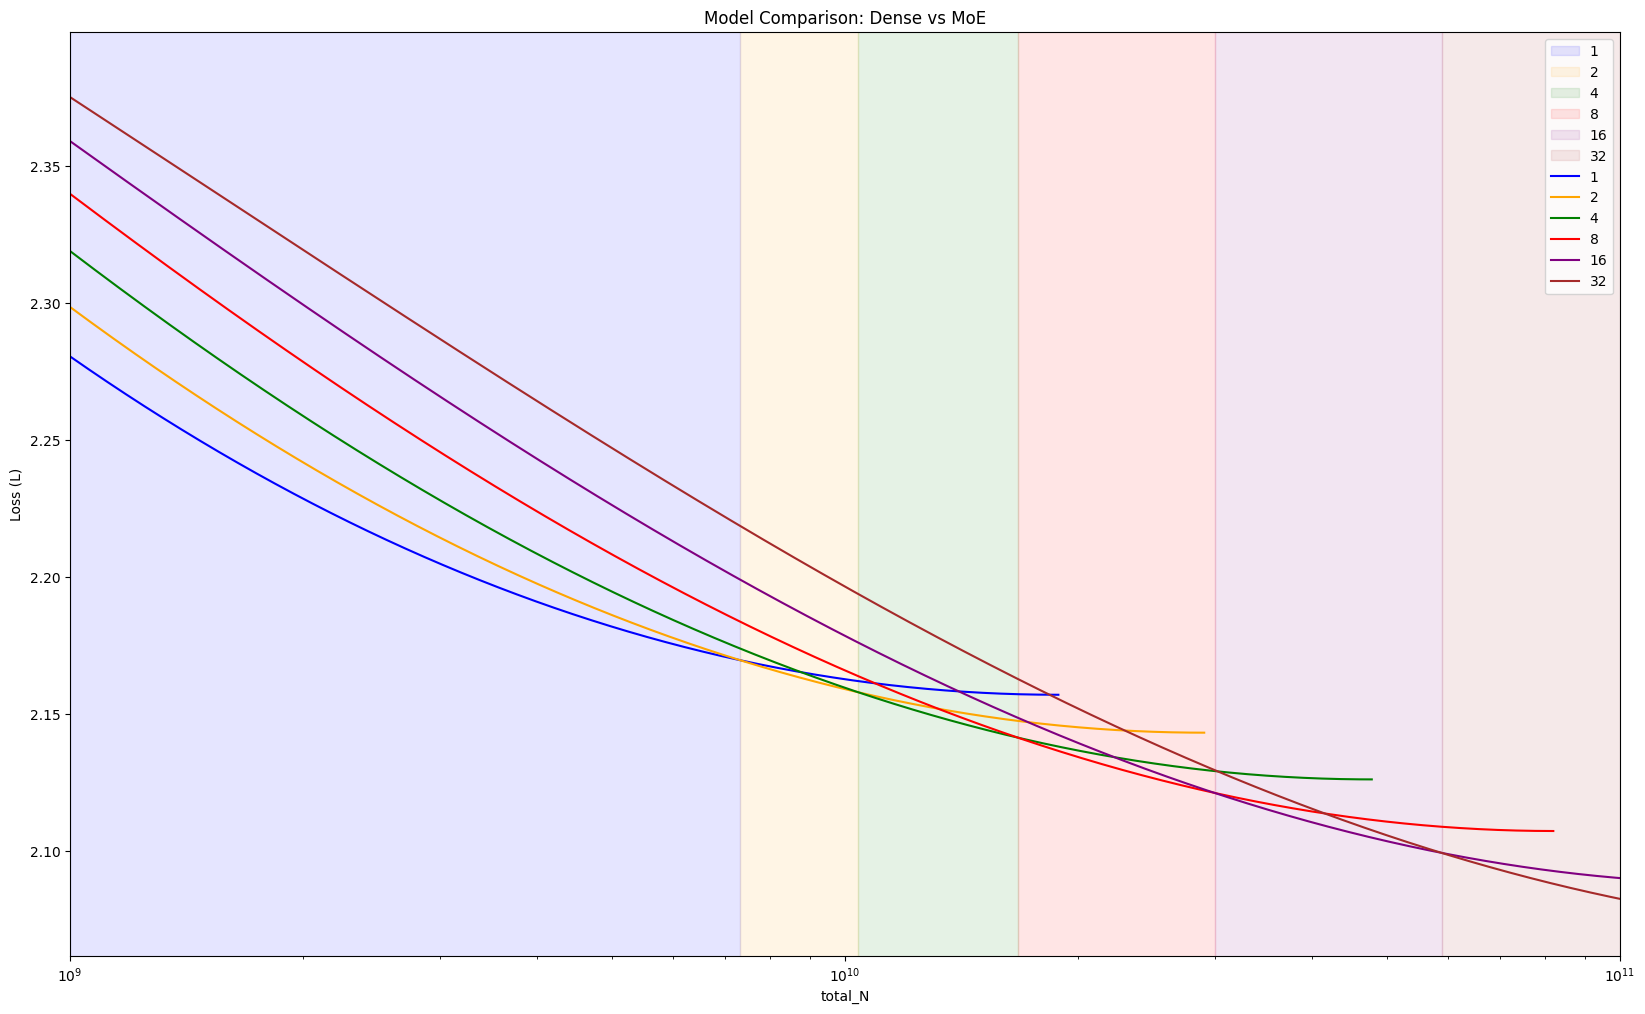

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



2.340344988477679 2.0795499680017957


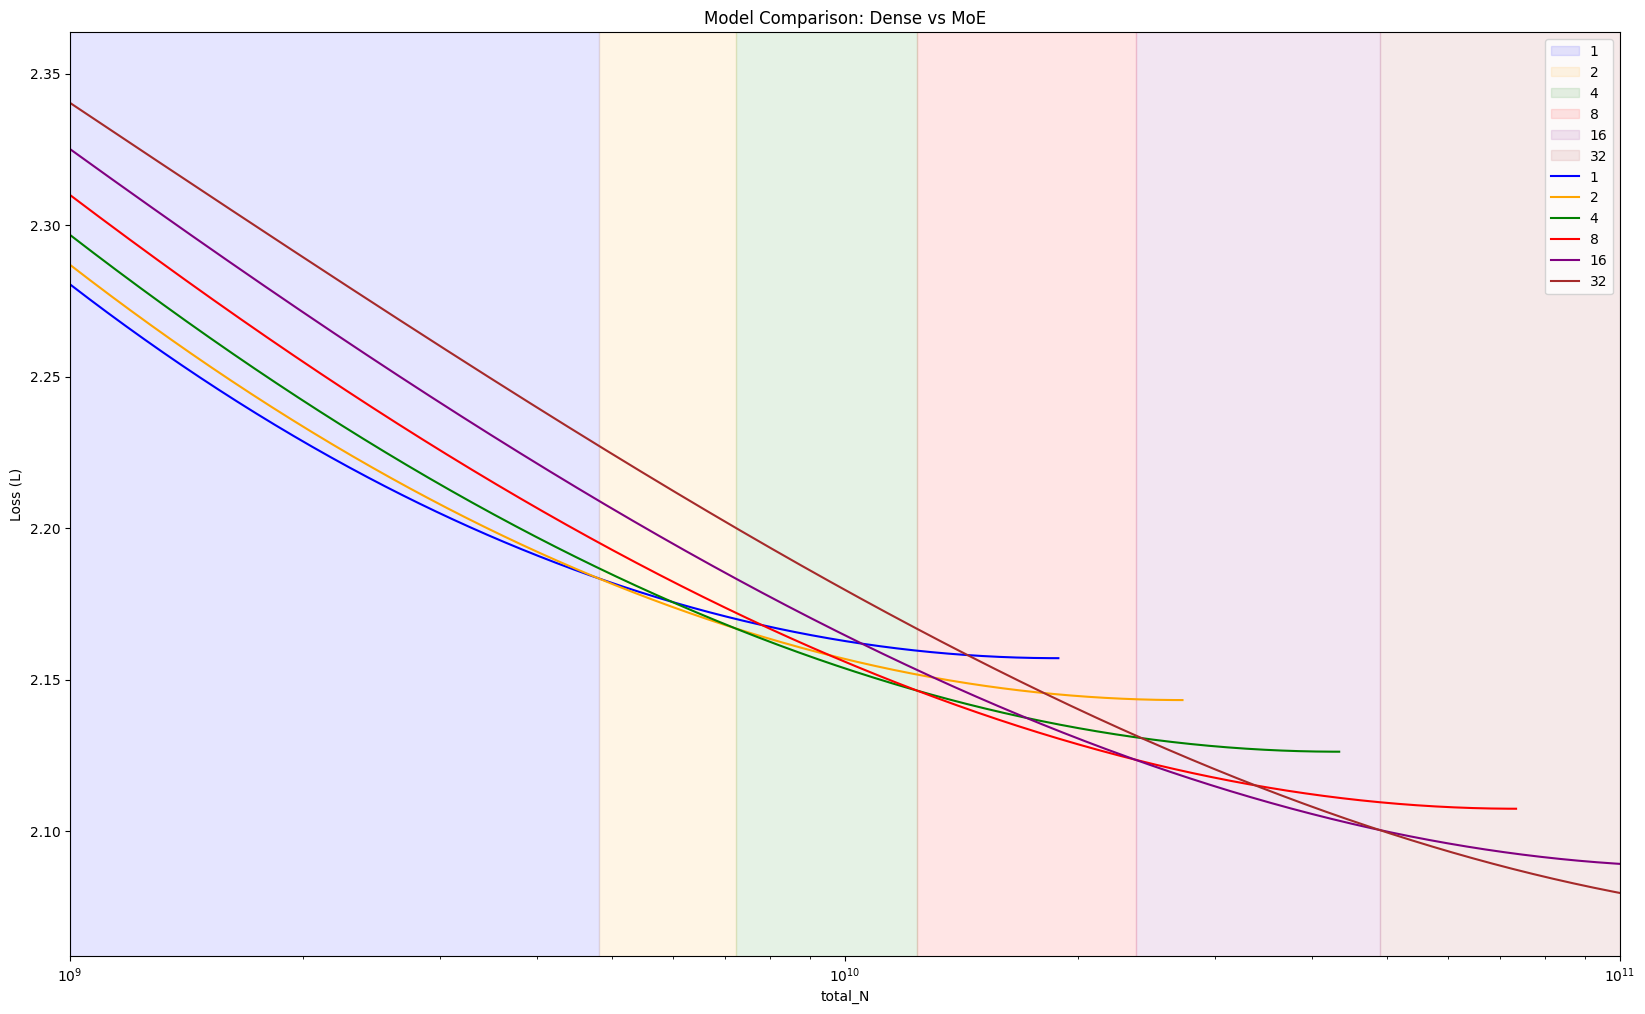

rm: cannot remove './analysis_plots.zip': No such file or directory
  adding: analysis_plots/ (stored 0%)
  adding: analysis_plots/best_for_N.pdf (deflated 22%)
  adding: analysis_plots/best_for_N_kvcache.pdf (deflated 21%)


,N_active_w_embedding,D,E,L,D/N,L_pred,error,N_total,FLOPS,log_FLOPS,flops_overhead


In [48]:
# @title
predicted_loss = predict_loss_joined(N=N, D=D, E=E, **res)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'black']


predicted_loss = predict_loss_joined(N=N, D=D, E=E, **res)

def plot_L_N_kvcache_inference_optimal(res, budget,
                                       n_kv_tokens, n_inference_tokens, is_log_y,
                                       subtract_dataset_entropy, ending_mode='all',
                                       points_to_plot = None, Es = [1, 2, 4, 8, 16, 32],
                                       path_to_save = None):



    budget_exponent = np.log10(budget)
    total_N = np.logspace(budget_exponent / 2 - 2, budget_exponent / 2, num=1000, dtype='float64')
    Ls = [f'L_{e}' for e in Es]
    rows = []
    x_column = 'total_N'
    for i in range(len(total_N)):
        row = {x_column: total_N[i]}
        if n_kv_tokens > 0:
            dm = get_dm_from_N_total_with_embeddings_with_kv(total_N[i], DV, 1, 0)
            kv_size = n_kv_tokens * dm ** 2 / 32
            memory_constraint = total_N[i] + kv_size
        else:
            memory_constraint = total_N[i]
        for exp_rate in Es:
            dm = get_dm_from_N_total_with_embeddings_with_kv(memory_constraint, DV, exp_rate, n_kv_tokens)
            # dm = get_dm_from_N_total_with_embeddings_with_kv(total_N[i], 0, exp_rate, n_kv_tokens)
            active_N_nonembed = (13 / 64) * dm**3
            embed_size = 2 * dm * DV
            active_N_with_embed = active_N_nonembed + embed_size
            inference_cost = 2 * n_inference_tokens * active_N_with_embed
            train_budget = budget - inference_cost
            D = train_budget / (6 * active_N_with_embed)
            row[f'D_{exp_rate}'] = D
            # row[f'active_N_{exp_rate}'] = active_N_nonembed
            row[f'active_N_{exp_rate}'] = active_N_with_embed
            row[f'dm_{exp_rate}'] = dm

        rows.append(row)

    df = pd.DataFrame(rows)
    for e in Es:
        L = predict_loss_joined(N=torch.tensor(df[f'active_N_{e}']), D=torch.tensor(df[f'D_{e}']), E=torch.tensor([e] * len(df)), **res)
        if subtract_dataset_entropy:
            L -= res['C']

        df[f"L_{e}"] = L.numpy()



    df['optimal'] = df[Ls].idxmin(axis=1)

    # Plotting
    plt.figure(figsize=(20, 12))

    # Determine the min and max values for the x and y axes
    min_x = df[x_column].min()
    max_x = df[x_column].max()
    min_y = df[Ls].min().min()
    max_y = df[Ls].max().max()

    for e, color in zip(Es, colors):
        optimal_interval = (df['optimal'] == f'L_{e}')
        if not optimal_interval.any():
            continue
        last_true_index = df[optimal_interval].index[-1]
        if last_true_index < df.shape[0] - 1:
            optimal_interval[last_true_index + 1] = True

        plt.fill_between(df['total_N'], -1, 1000,
                    where=optimal_interval,
                        color=color, alpha=0.1, label=str(e))

    # Determine the min and max values for the x and y axes
    min_x = df[x_column].min()
    max_x = df[x_column].max()
    if ending_mode == 'all':
        min_y = df[Ls].min().min()
        max_y = df[Ls].max().max()
    elif ending_mode == 'constant' or ending_mode == 'cut':
        min_y = float('inf')
        max_y = -float('inf')
    else:
        raise ValueError(f'Unknwon ending_mode: {ending_mode}')

    for e, color in zip(Es, colors):
        if ending_mode == 'all':
            sns.lineplot(data=df, x=x_column, y=f'L_{e}', label=f'{e}', color=color)
            # sns.lineplot(data=df, x=f"active_N_{e}", y=f'L_{e}', label=f'{e}', color=color)
        elif ending_mode == 'constant':
            dfcp = df.copy()
            optimal_N_idx = dfcp[f'L_{e}'].idxmin()
            optimal_N = dfcp.iloc[optimal_N_idx]['total_N']
            optimal_L = dfcp.iloc[optimal_N_idx][f'L_{e}']
            dfcp.loc[df['total_N'] > optimal_N, f'L_{e}'] = optimal_L

            min_y = min(min_y, dfcp[f'L_{e}'].min())
            max_y = max(max_y, dfcp[f'L_{e}'].max())

            sns.lineplot(data=dfcp, x=x_column, y=f'L_{e}', label=f'{e}', color=color)
        elif ending_mode == 'cut':
            optimal_N_idx = df[f'L_{e}'].idxmin()
            optimal_N = df.iloc[optimal_N_idx]['total_N']
            subdf = df[df['total_N'] <= optimal_N]

            min_y = min(min_y, subdf[f'L_{e}'].min())
            max_y = max(max_y, subdf[f'L_{e}'].max())

            sns.lineplot(data=subdf, x=x_column, y=f'L_{e}', label=f'{e}', color=color)
        else:
            raise ValueError(f'Unknwon ending_mode: {ending_mode}')

    if points_to_plot is not None:
        for e, color in zip(Es, colors):
            same_e_subset = points_to_plot[points_to_plot[f'E'] == e]
            diff = 0 if not subtract_dataset_entropy else res['C']
            plt.scatter(same_e_subset['N_total'], same_e_subset['L'] - diff, marker='o', s=50, color=color)

    plt.xscale('log')
    plt.xlabel(x_column)
    if is_log_y:
        plt.yscale('log')
    plt.ylabel('Loss (L)')
    plt.title('Model Comparison: Dense vs MoE')

    # Example: Set custom limits for the x and y axes
    plt.xlim(min_x, max_x)
    print(max_y, min_y)
    # y_margins = (max_y - min_y) / 10
    # plt.ylim(min_y - min_y / 1, max_y + max_y / 100)
    plt.ylim(min_y - min_y / 100, max_y + max_y / 100)

    # plt.axhline(y=2.6491099085, color='r', linestyle='-')
    if path_to_save:
        plt.savefig(path_to_save, bbox_inches='tight')

    plt.legend()
    plt.show()

    return df



# predicted_loss_test = predict_loss_joined(N=N_test, D=D_test, E=E_test, **res)

# ad_hoc_table = pd.DataFrame(columns=['N', 'D', 'E', 'L'])
# ad_hoc_table = pd.DataFrame({
#     "N_active_w_embedding": N_test.numpy(),
#     "D": D_test.numpy(),
#     "E": E_test.numpy(),
#     "L": L_test.numpy(),
#     "D/N": (D_test/N_test).numpy(),
#     "L_pred": predicted_loss_test.numpy(),
#     "error": (predicted_loss_test - L_test).numpy(),
#     }
# )

predicted_loss_train = predict_loss_joined(N=N, D=D, E=E, **res)
ad_hoc_table = pd.DataFrame({
    "N_active_w_embedding": N.numpy(),
    "D": D.numpy(),
    "E": E.numpy(),
    "L": L.numpy(),
    "D/N": (D/N).numpy(),
    "L_pred": predicted_loss_train.numpy(),
    "error": (predicted_loss_train - L).numpy(),
    }
)


# N, D, L, E, N_test, D_test, L_test, E_test
# fill with N, D, E, L and {N, D, E, L}_test
# dm = get_dm_from_N_active_nonembedding(ad_hoc_table['N_active_nonembedding'])
dm = ad_hoc_table['N_active_w_embedding'].apply(get_dm_from_N_active_w_embedding, args=(DV,))
# print(dm)
ad_hoc_table['N_total'] = 2*DV*dm + (4 + 9*ad_hoc_table['E']) * dm**3 / 64
# ad_hoc_table['N_active_w_embedding'] = 2*DV*dm + (13 / 64) * dm**3
ad_hoc_table['FLOPS'] = 6 * ad_hoc_table['N_active_w_embedding'] * ad_hoc_table['D']
ad_hoc_table['log_FLOPS'] = np.log10(ad_hoc_table['FLOPS'])

px.histogram(ad_hoc_table['log_FLOPS']).show()

# subset = ad_hoc_table[(1.5e19 <= ad_hoc_table['FLOPS']) & (ad_hoc_table['FLOPS'] <=2e19)]
# lo_f, hi_f = 18.8, 19.0
# lo_f, hi_f = 20.0, 20.2
# lo_f, hi_f = 20.8, 21.0
# lo_f, hi_f = 20.2, 20.4
# lo_f, hi_f = 25, 25
lo_f, hi_f = 22, 22
# lo_f, hi_f = 19.9, 20.0
# lo_f, hi_f = np.log10(0.52e20), np.log10(0.54e20)


ad_hoc_table["flops_overhead"] = ad_hoc_table['FLOPS']/10**((lo_f + hi_f) / 2)
subset = ad_hoc_table[(lo_f <= ad_hoc_table['log_FLOPS']) & (ad_hoc_table['log_FLOPS'] <= hi_f)]

plot_L_N_kvcache_inference_optimal(
    budget=10**((lo_f + hi_f) / 2),
    res=res,
    n_kv_tokens=0,
    n_inference_tokens=0,
    is_log_y=False,
    subtract_dataset_entropy=False,
    ending_mode='cut',
    points_to_plot = subset,
    path_to_save=f'{PLOTS_DIR}/best_for_N.pdf'
)
plot_L_N_kvcache_inference_optimal(
    budget=10**((lo_f + hi_f) / 2),
    res=res,
    n_kv_tokens=8192,
    n_inference_tokens=0,
    is_log_y=False,
    subtract_dataset_entropy=False,
    ending_mode='cut',
    points_to_plot = subset,
    path_to_save=f'{PLOTS_DIR}/best_for_N_kvcache.pdf'
)

save_to_zip()

# inference_budget = 1e22
# inference_tokens = 1e12
# plot_L_N_kvcache_inference_optimal(
#     budget=10**((lo_f + hi_f) / 2) + inference_budget,
#     res=res,
#     n_kv_tokens=0,
#     n_inference_tokens=inference_tokens,
#     is_log_y=False,
#     subtract_dataset_entropy=False,
#     ending_mode='cut',
#     points_to_plot = subset
# )

subset.sort_values(by='error', key=abs, ascending=False)

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



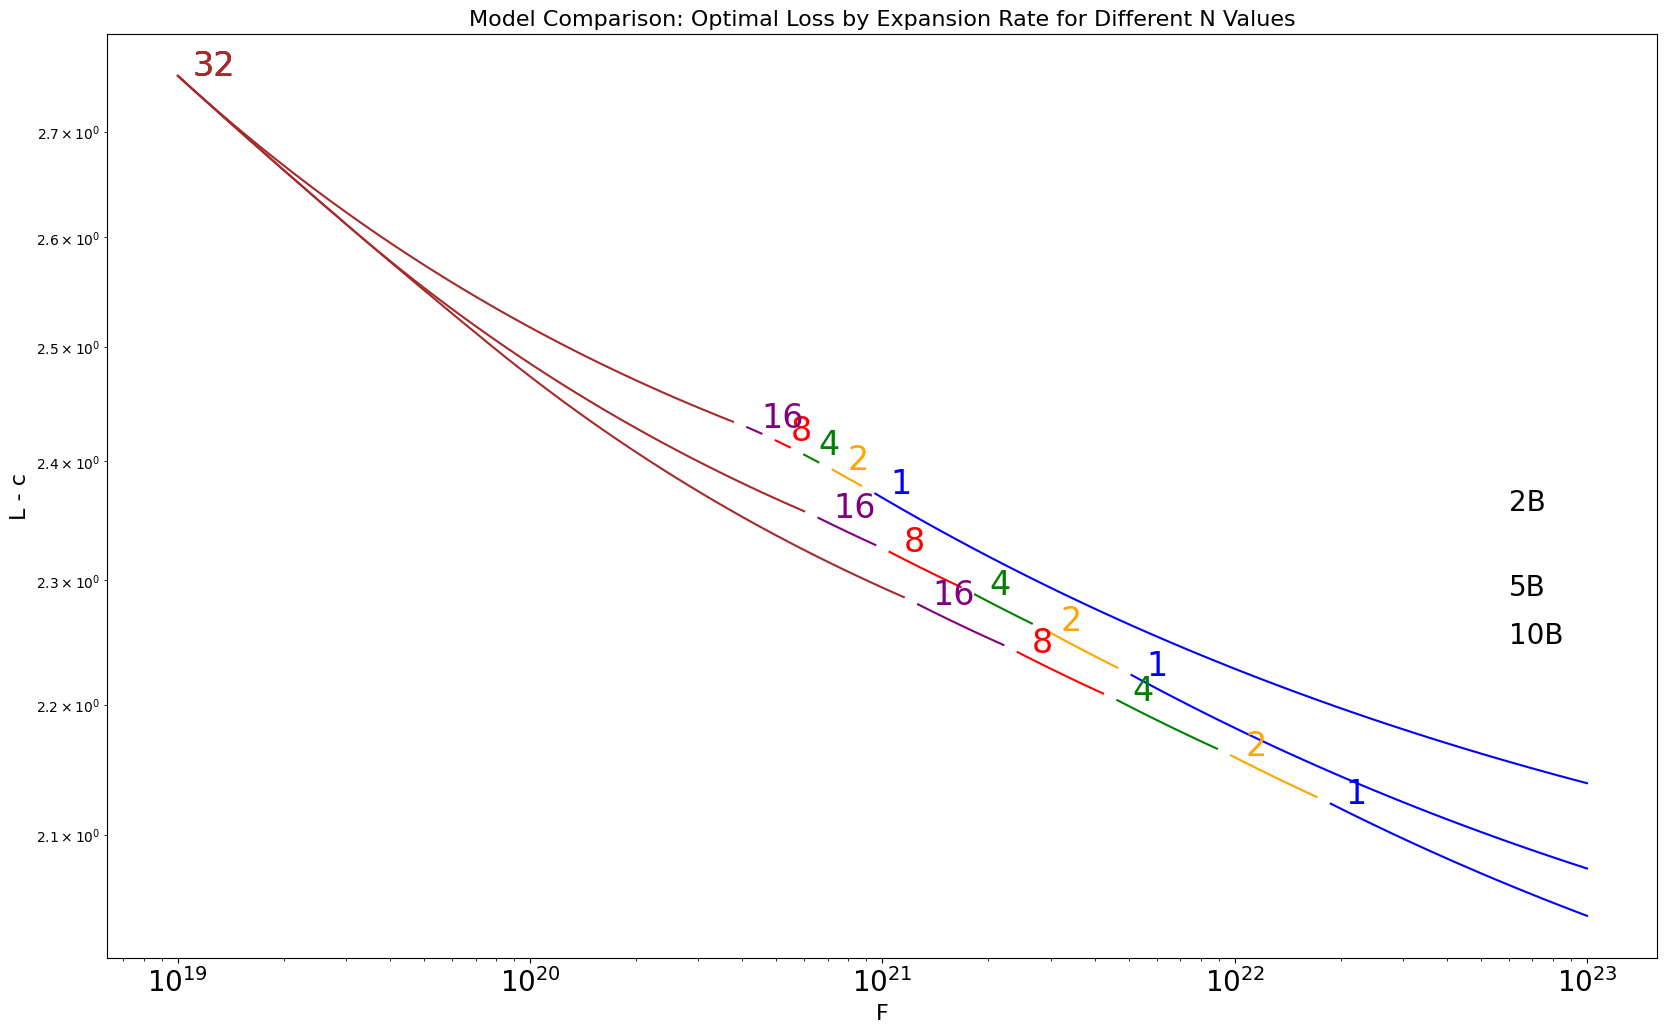

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

<ipython-input-13-60a104f17ca9>:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



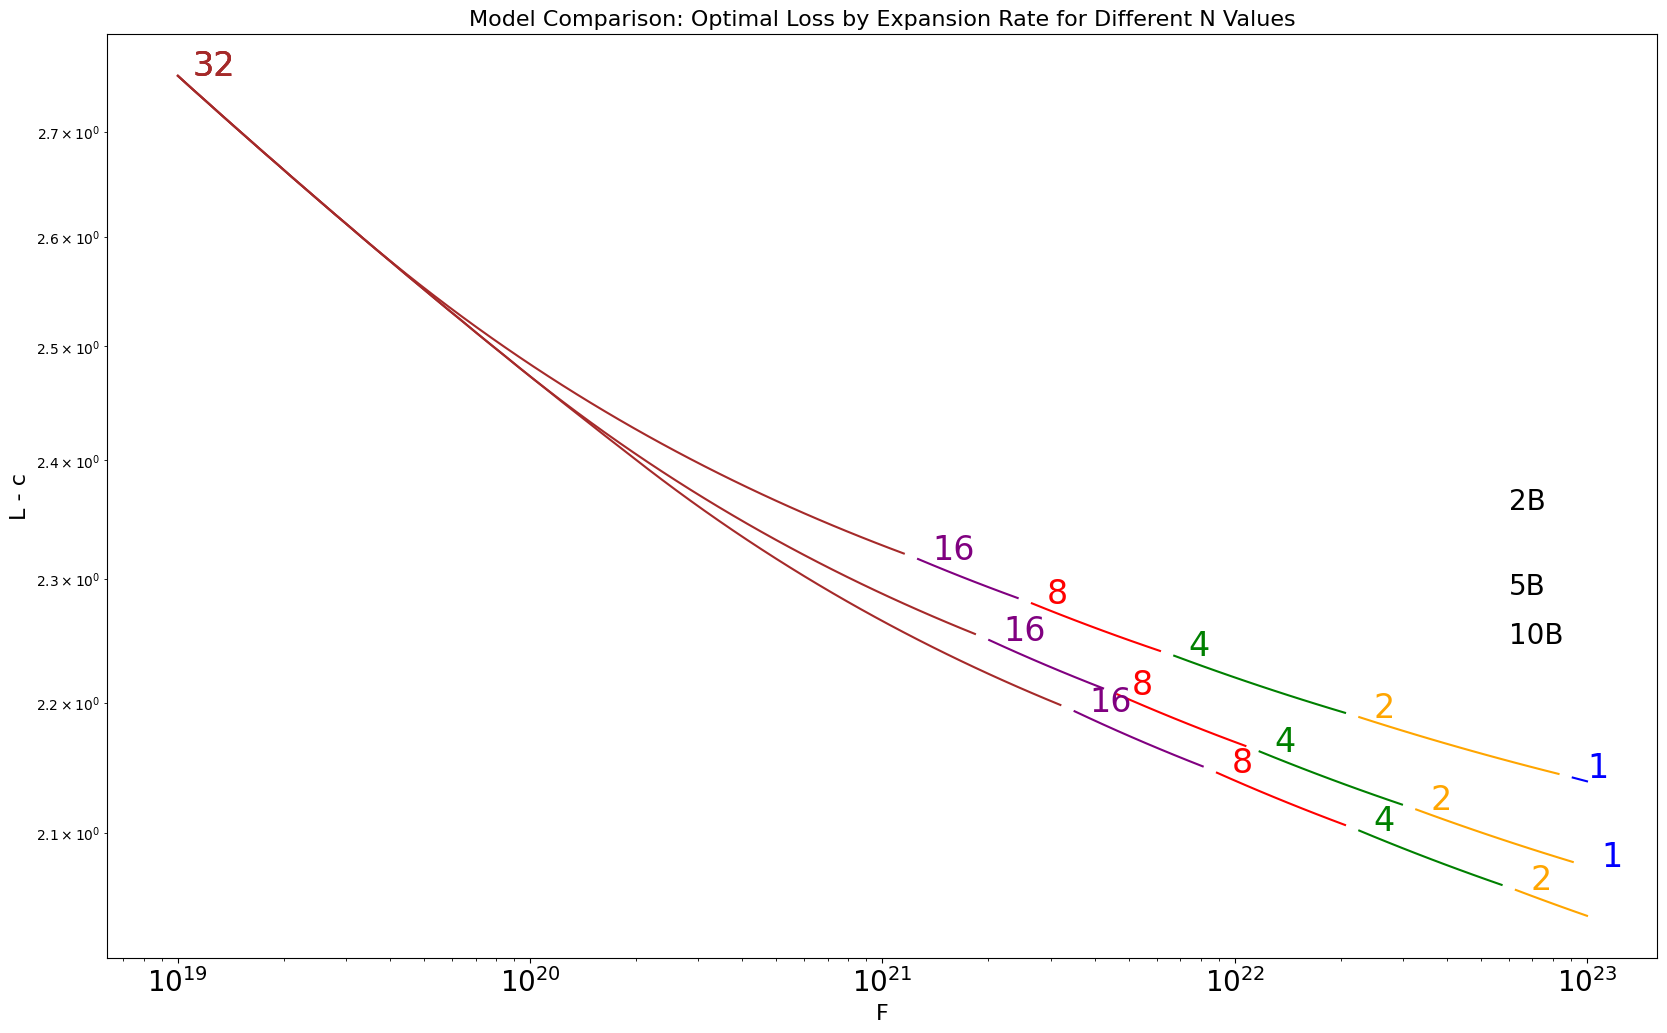

In [ ]:
llama405budget = 3.8e25
llama70budget = llama405budget * (70/405)
llama8budget = llama405budget * (8/405)
import random

# Define the different N values to use
# def plot_L_F(fits, Ns, sizes_labels, Fs, n_kv_tokens, n_inference_tokens, path_to_save = None):
def plot_L_F(res, Ns, sizes_labels, Fs, n_kv_tokens, n_inference_tokens = None,
             inference_cost_times = None, landmark_budgets = [llama8budget, llama70budget, llama405budget],
             landmark_labels = ['Llama 3 8B', 'Llama 3 70B', 'Llama 3 405B'],
             path_to_save = None, Es=[1, 2, 4, 8, 16, 32]):
    plt.figure(figsize=(20, 12))

    if not isinstance(n_kv_tokens, list):
        n_kv_tokens = [n_kv_tokens] * len(Ns)

    Ls = [f'L_{e}' for e in Es]
    # Loop over the different N values
    for idx, (N, n_kv_tokens_of_N, size_label) in enumerate(zip(Ns, n_kv_tokens, sizes_labels)):
        rows = []
        # actual_N = N + get_Nkv_per_token_from_N(N, DV, 1) * n_kv_tokens_of_N
        # actual_N = N + get_Nkv_per_token_from_N(N, DV, 1) * n_kv_tokens_of_N
        actual_N = N + get_Nkv_per_token_from_N_total_with_embeddings(N, DV, 1) * n_kv_tokens_of_N
        for i in range(len(Fs)):
            row = {'F': Fs[i]}
            for exp_rate in Es:
                    best_L = float('inf')
                    best_N = None
                    candidate_Ns = []
                    candidate_Ds = []
                    candidate_Es = []
                    for candidate_N in np.logspace(np.log10(actual_N) / 4, np.log10(actual_N), 100):
                        dm = get_dm_from_N_total_with_embeddings_with_kv(candidate_N, DV, exp_rate, n_kv_tokens_of_N)
                        active_N_nonembed = (13 / 64) * dm**3
                        embed_size = 2 * dm * DV
                        active_N_with_embed = active_N_nonembed + embed_size
                        assert inference_cost_times is None or n_inference_tokens is None
                        if inference_cost_times is not None:
                            train_budget = Fs[i] / (1 + inference_cost_times)
                        elif n_inference_tokens is not None:
                            inference_cost = 2 * n_inference_tokens * active_N_with_embed
                            train_budget = Fs[i] - inference_cost
                        else:
                            train_budget = Fs[i]
                        D = train_budget / (6 * active_N_with_embed)
                        # candidate_Ns.append(active_N_nonembed)
                        candidate_Ns.append(active_N_with_embed)
                        candidate_Ds.append(D)
                        candidate_Es.append(exp_rate)
                        # candidate_L = predict_loss_joined(N=torch.tensor([active_N_nonembed]), D=torch.tensor([D]), E=torch.tensor([exp_rate]), **res).item()
                        # candidate_L = rand_float = random.uniform(2, 4)
                        # candidate_L -= res['C']
                        # if candidate_L < best_L:
                        #     best_L = candidate_L
                        #     row[f'L_{exp_rate}'] = candidate_L - res['C']
                        #     row[f'D_{exp_rate}'] = D
                        #     row[f'active_N_{exp_rate}'] = active_N_nonembed
                        # else:
                        #     break
                    # Losses = predict_loss_joined(N=torch.tensor([active_N_nonembed]), D=torch.tensor([D]), E=torch.tensor([exp_rate]), **res).item()
                    candidate_Ls = predict_loss_joined(N=torch.tensor(candidate_Ns), D=torch.tensor(candidate_Ds), E=torch.tensor(candidate_Es), **res)
                    # candidate_Ls -= res['C']
                    min_idx = np.argmin(candidate_Ls)
                    row[f'L_{exp_rate}'] = candidate_Ls[min_idx].item()
                    row[f'D_{exp_rate}'] = candidate_Ds[min_idx]
                    row[f'active_N_{exp_rate}'] = candidate_Ns[min_idx]
            rows.append(row)

        df = pd.DataFrame(rows)

        df['optimal'] = df[Ls].idxmin(axis=1)
        df['min_loss'] = df[Ls].min(axis=1)

        # Plot only the optimal points with the corresponding color and line style for each N value
        for e, color in zip(Es, colors):
            optimal_indices = df['optimal'] == f'L_{e}'
            label = f'Optimal {e} (N = {N:.0e})'
            start_y = df[optimal_indices]['min_loss'].max()
            start_x = df[optimal_indices]['F'].min()
            sns.lineplot(data=df[optimal_indices], x='F', y='min_loss', label='_nolegend_', color=color) #, linestyle=['-', '-', '-'][idx])
            plt.text(start_x * 1.1, start_y * 1.0, f"{e}", color=color, fontsize=24)

        plt.text(Fs.max() * 0.6, 1.1 * df['min_loss'].min(), size_label, color='black', fontsize=20, ha='left', va='bottom')


    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('F', fontsize=16)
    plt.ylabel('L - c', fontsize=16)
    plt.title('Model Comparison: Optimal Loss by Expansion Rate for Different N Values', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed

    for landmark_budget, landmark_label, linestyle in zip(landmark_budgets, landmark_labels, ['-', '--', '-.']):
        plt.axvline(x=landmark_budget, color='black', linestyle=linestyle, linewidth=2, label=landmark_label)

    if landmark_budgets and landmark_labels:
        plt.legend(loc='lower left', fontsize=24)

    if path_to_save:
        plt.savefig(path_to_save, bbox_inches='tight')
    plt.show()



a100_hour_flops = (1/2) * 312 * 10**12 * 3600 # 50% mfu * bfloat16 perf. * seconds in an hour

plot_L_F(res, [2e9, 5e9, 10e9],
         sizes_labels = ["2B", "5B", "10B"],
         Fs = np.logspace(19, 23, 100),
         n_kv_tokens=0, n_inference_tokens=0,
         landmark_budgets = [],
         landmark_labels = [],
         path_to_save=f'{PLOTS_DIR}/optimal_L_F.pdf')

plot_L_F(res, [2e9, 5e9, 10e9],
         sizes_labels = ["2B", "5B", "10B"],
         Fs = np.logspace(19, 23, 100),
         n_kv_tokens=32768, n_inference_tokens=0,
         landmark_budgets = [],
         landmark_labels = [],
         path_to_save=f'{PLOTS_DIR}/optimal_L_F_32k_kvcache.pdf')

# plot_L_F(res, [8e9, 70e9, 405e9],
#          sizes_labels = ["2B", "5B", "10B"],
#          Fs = np.logspace(21, 26, 100),
#          n_kv_tokens=0, n_inference_tokens=0,
#          landmark_budgets = [llama8budget, llama70budget, llama405budget],
#          landmark_labels = ['Llama 8B', "Llama 70B", "Llama 405B"],
#          path_to_save=f'{PLOTS_DIR}/optimal_L_F_llamas.pdf')


save_to_zip()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import numpy as np
import plotly.graph_objects as go



def run(table, ids, line1_ids, line2_ids,
        compute_optimal, path_to_save=None, n_inference_tokens=0,
        yaxis_range=None, xaxis_range=None
):
    # Filter & compute flops
    table = table[table['sys/id'].isin(ids)].copy()
    table['flops'] = 6 * table['tokens'] * table['active_with_embed'] + 2 * n_inference_tokens * table['active_with_embed']

    # Check columns
    req_cols = ["args/expansion_rate", "flops", "final_eval_capacity_factor_1.5"]
    if not all(c in table.columns for c in req_cols):
        raise ValueError(f"DataFrame must contain columns: {req_cols}")

    # Lines to intersect
    line1 = table[table['sys/id'].isin(line1_ids)].sort_values('flops')
    line2 = table[table['sys/id'].isin(line2_ids)].sort_values('flops')
    if len(line1) < 2 or len(line2) < 2:
        raise ValueError("Each line must have at least two points.")

    m1, b1 = np.polyfit(line1['flops'], line1['final_eval_capacity_factor_1.5'], 1)
    m2, b2 = np.polyfit(line2['flops'], line2['final_eval_capacity_factor_1.5'], 1)
    intersection_flops = (b2 - b1) / (m1 - m2) if m1 != m2 else None

    # Plotly Express line plot
    df_sorted = table.sort_values(['args/expansion_rate','flops'])
    df_sorted['Expansion Rate'] = df_sorted['args/expansion_rate']
    fig = px.line(
        df_sorted,
        x='flops',
        y='final_eval_capacity_factor_1.5',
        color='Expansion Rate',
        markers=True,
        title="FLOPs vs Final Eval Capacity Factor (Colored by Expansion Rate)",
        template='plotly_white',
    )
    fig.update_traces(
       marker={
           'size': 20
       }
    )

    # Vertical line at compute_optimal
    fig.add_vline(
        x=compute_optimal,
        line_dash='dash',
        line_color='red',
        # annotation_text='E=1 Compute Optimal'
    )
    fig.add_trace(go.Scatter(
        x=[compute_optimal, compute_optimal],
        y=yaxis_range,  # Use your y-range
        mode='lines',
        line=dict(dash='dash', color='red'),
        name='E=1 Compute Optimal',  # Legend label
        showlegend=True,
    ))
    # Intersection line + annotation
    if intersection_flops and df_sorted['flops'].min() <= intersection_flops <= df_sorted['flops'].max():
        fig.add_vline(x=intersection_flops, line_dash='dash', line_color='green')
        # Shading if intersection > compute_optimal
        if intersection_flops > compute_optimal:

            x0, x1 = compute_optimal, intersection_flops
            y0, y1 = -1, 10


            fig.add_trace(go.Bar(
                x=[(x0 + x1) / 2],          # midpoint
                y=[y1 - y0],
                width=(x1 - x0),           # span from x0 to x1
                name="E=2 Memory Optimal",
                marker=dict(
                    color="rgba(0,0,0,0)",             # Fully transparent bar
                    pattern_shape="/",  # e.g. '/', '\\', 'x', '.', '|-', 'brick', etc.
                    pattern_fgcolor="rgba(0,0,0,0.4)",
                    pattern_solidity=0.2,
                    pattern_size=20
                ),
                showlegend=False
            ))

    fig.update_layout(
        xaxis_title='FLOPs',
        yaxis_title='Eval Loss',
        autosize=False,
        width=1500,
        height=1000,
        yaxis_range=yaxis_range,
        xaxis_range=xaxis_range,
        font={
            'size': 30
        }
    )
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.75
    ))
    if path_to_save:
        fig.write_image(path_to_save)
    fig.show()

ids = [
        "LLMRANDOM-25496", "LLMRANDOM-25497", "LLMRANDOM-29053", "LLMRANDOM-29055", "LLMRANDOM-25498", "LLMRANDOM-25499", #E=1
        "LLMRANDOM-28389", "LLMRANDOM-28390", "LLMRANDOM-29056", "LLMRANDOM-29058", "LLMRANDOM-28391", "LLMRANDOM-28392", #E=2
        # "LLMRANDOM-28428", "LLMRANDOM-28429", "LLMRANDOM-28429", "LLMRANDOM-28430", #E=4
    ]
line1_ids = ["LLMRANDOM-29055", "LLMRANDOM-25498"]
line2_ids = ["LLMRANDOM-29058", "LLMRANDOM-28391"]

run(
    table.copy(), ids, line1_ids, line2_ids, 0.53e20,
    n_inference_tokens=0, path_to_save=f'{PLOTS_DIR}/real_life_optimal_1.3B.pdf',
    yaxis_range=(2.5, 2.75)
)

ids = [
        "LLMRANDOM-23623", "LLMRANDOM-23624", "LLMRANDOM-23625", "LLMRANDOM-23626", #E=1
        "LLMRANDOM-28468", "LLMRANDOM-28469", "LLMRANDOM-28470", "LLMRANDOM-28471", #E=2
        # "LLMRANDOM-28428", "LLMRANDOM-28429", "LLMRANDOM-28429", "LLMRANDOM-28430", #E=4
    ]
line1_ids = ["LLMRANDOM-23624", "LLMRANDOM-23625"]
line2_ids = ["LLMRANDOM-28469", "LLMRANDOM-28470"]

compute_optimal_guess = 6 * (310e6)**2 * 5 # ratio - 7.5
run(table.copy(), ids, line1_ids, line2_ids, compute_optimal_guess,
    path_to_save=f'{PLOTS_DIR}/370M_comparison.pdf',
    yaxis_range=(2.9, 3.3)
)

save_to_zip()

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def plot_L_F_plotly(res, Ns, sizes_labels, Fs, n_kv_tokens, n_inference_tokens=None,
                    inference_cost_times=None, landmark_budgets=None, landmark_labels=None,
                    path_to_save=None, Es=[1,2,4,8,16,32]):
    fig = go.Figure()

    if not isinstance(n_kv_tokens, list):
        n_kv_tokens = [n_kv_tokens]*len(Ns)

    Ls = [f'L_{e}' for e in Es]
    colors = ["blue","red","green","orange","purple","brown"]
    for idx, (N, kv, size_label) in enumerate(zip(Ns, n_kv_tokens, sizes_labels)):
        rows = []
        actual_N = N + get_Nkv_per_token_from_N_total_with_embeddings(N, DV, 1)*kv
        for fval in Fs:
            row = {'F': fval}
            for e in Es:
                candN, candD = [], []
                for cN in np.logspace(np.log10(actual_N)/4, np.log10(actual_N), 100):
                    dm = get_dm_from_N_total_with_embeddings_with_kv(cN, DV, e, kv)
                    active = (13/64)*(dm**3) + 2*dm*DV
                    if inference_cost_times:
                        train_budget = fval/(1+inference_cost_times)
                    elif n_inference_tokens:
                        train_budget = fval - 2*n_inference_tokens*active
                    else:
                        train_budget = fval
                    D = train_budget/(6*active)
                    candN.append(active)
                    candD.append(D)
                cL = predict_loss_joined(N=torch.tensor(candN),
                                         D=torch.tensor(candD),
                                         E=torch.tensor([e]*len(candN)), **res)
                i_min = np.argmin(cL)
                row[f'L_{e}'] = cL[i_min].item()
                row[f'D_{e}'] = candD[i_min]
                row[f'active_{e}'] = candN[i_min]
            rows.append(row)

        df = pd.DataFrame(rows)
        df['optimal'] = df[Ls].idxmin(axis=1)
        df['min_loss'] = df[Ls].min(axis=1)

        for c, e in zip(colors, Es):
            mask = df['optimal'] == f'L_{e}'
            fig.add_trace(go.Scatter(x=df[mask]['F'],
                                     y=df[mask]['min_loss'],
                                     mode='lines',
                                     line=dict(color=c),
                                     name=f"N={N:.0e}, e={e}"))
            if mask.any():
                lastF = df[mask]['F'].iloc[-1]
                lastL = df[mask]['min_loss'].iloc[-1]
                fig.add_annotation(x=lastF, y=lastL, text=str(e), showarrow=False, font=dict(color=c))

        fig.add_annotation(x=Fs.max()*0.6, y=1.1*df['min_loss'].min(),
                           text=size_label, showarrow=False, font=dict(size=16))

    fig.update_layout(xaxis_type="log", yaxis_type="log",
                      xaxis_title="F", yaxis_title="L - c",
                      title="Optimal Loss by Expansion Rate")

    if landmark_budgets and landmark_labels:
        for lb, lbl in zip(landmark_budgets, landmark_labels):
            fig.add_vline(x=lb, line_width=2, line_dash="dash", annotation_text=lbl, annotation_position="bottom")


    if path_to_save:
        fig.write_image(path_to_save)
    fig.show()

# Example usage
plot_L_F_plotly(res, [2e9,5e9,1e10],
                sizes_labels=["2B","5B","10B"],
                Fs=np.logspace(19, 23, 100),
                n_kv_tokens=0, n_inference_tokens=0,
                landmark_budgets=[], landmark_labels=[],
                path_to_save=f'{PLOTS_DIR}/optimal_L_F_plotly.pdf')

save_to_zip()

In [ ]:
import matplotlib.ticker as mticker

def custom_formatter(x, _):
    if x >= 1e12:
        return '{:.0f}T'.format(x * 1e-12)
    elif x >= 1e9:
        return '{:.0f}B'.format(x * 1e-9)
    elif x >= 1e6:
        return '{:.0f}M'.format(x * 1e-6)
    else:
        return '{:.0f}'.format(x)

ml_formatter = mticker.FuncFormatter(custom_formatter)
TITLE_SIZE = 16
LABEL_SIZE = 14
# Constants stored in a dictionary
# params = {
#     "c": 2.4,
#     "a": 803.0,
#     "alpha": -0.34,
#     "delta": 4.80,
#     "gamma": -0.29,
#     "b": 519.0,
#     "beta": -0.30,
#     "omega": 4.31,
#     "zeta": -0.19,
#     "E_start": 2.6527,
#     "E_max": 4.9748,
#     "phi": 0.68
# }

#params = {k: np.float64(v) for k, v in params.items()}

# Function for E_prime
# def get_E_prime(E, params):
#     indicator = 1.0 * (E == 1)
#     term2 = indicator * params["phi"]
#     term3 = 1 / (1/params["E_start"] - 1/params["E_max"])
#     term4 = params["E_max"]
#     return 1/(1 / (E + term2 - 1 + term3) + 1 / term4)

# Function for L
# def get_L(N_act, D, E_prime, params):
#     term1 = params["a"] * (E_prime ** params["delta"]) * (N_act ** (params["alpha"] + params["gamma"] * np.log(E_prime)))
#     term2 = params["b"] * (E_prime ** params["omega"]) * (D ** (params["beta"] + params["zeta"] * np.log(E_prime)))
#     return term1 + term2 + params["c"]


def plot_L_limit_vs_D(params, D_range, e_values, path_to_save = None):
    data = []
    ax = plt.figure(figsize=(10, 6)).gca()


    for e, color in zip(e_values, colors):
        E_prime = get_E_prime(e, params)
        L_limit = params["b"] * (E_prime ** params["omega"]) * (D_range ** (params["beta"] + params["zeta"] * np.log(E_prime)))

        sns.lineplot(data=pd.DataFrame({'D':D_range, 'L': L_limit }), x='D', y='L', label=str(e), color=color)

    # Plot
    # sns.lineplot(data=df, x="D", y="L_limit", hue="e")
    plt.xscale("log")  # Using log scale for D if range is large
    plt.yscale("log")  # Optionally, if L values also span large range
    plt.title(r"$L(\infty, D, E)$", fontsize=TITLE_SIZE)
    plt.xlabel("$D$", fontsize=LABEL_SIZE)
    plt.ylabel("$L - c$", fontsize=LABEL_SIZE)
    plt.legend(fontsize=LABEL_SIZE)
    plt.tick_params(axis='both', which='major', labelsize=LABEL_SIZE)  # Adjust 'labelsize' as needed
    # Set the x-axis formatter
    ax.xaxis.set_major_formatter(ml_formatter)


    if path_to_save:
        plt.savefig(path_to_save, bbox_inches='tight')

    plt.show()

def plot_L_limit_vs_N(params, N_range, e_values, path_to_save = None):
    data = []
    ax = plt.figure(figsize=(10, 6)).gca()


    for e, color in zip(e_values, colors):
        N_act = np.array([get_Nact_from_N(n, DV, e) for n in N_range])
        E_prime = get_E_prime(e, params)
        L_limit = params["a"] * (E_prime ** params["delta"]) * (N_act ** (params["alpha"] + params["gamma"] * np.log(E_prime)))

        sns.lineplot(data=pd.DataFrame({'N':N_range, 'L': L_limit }), x='N', y='L', label=str(e), color=color)


    # Plot
    # sns.lineplot(data=df, x="D", y="L_limit", hue="e")
    plt.xscale("log")  # Using log scale for D if range is large
    plt.yscale("log")  # Optionally, if L values also span large range
    plt.title(r"$L(N_{total}, \infty, E)$", fontsize=TITLE_SIZE)
    plt.xlabel("$N$", fontsize=LABEL_SIZE)
    plt.ylabel("$L - c$", fontsize=LABEL_SIZE)
    plt.legend(fontsize=LABEL_SIZE)
    plt.tick_params(axis='both', which='major', labelsize=LABEL_SIZE)  # Adjust 'labelsize' as needed

    # Set the x-axis formatter
    ax.xaxis.set_major_formatter(ml_formatter)


    if path_to_save:
        plt.savefig(path_to_save, bbox_inches='tight')

    plt.show()

def plot_L_limit_vs_N_act(params, N_act_range, e_values, path_to_save = None):
    data = []
    ax = plt.figure(figsize=(10, 6)).gca()


    for e, color in zip(e_values, colors):
        E_prime = get_E_prime(e, params)
        L_limit = params["a"] * (E_prime ** params["delta"]) * (N_range ** (params["alpha"] + params["gamma"] * np.log(E_prime)))

        sns.lineplot(data=pd.DataFrame({'N':N_range, 'L': L_limit }), x='N', y='L', label=str(e), color=color)

    # Plot
    plt.xscale("log")  # Using log scale for D if range is large
    plt.yscale("log")  # Optionally, if L values also span large range
    plt.title(r"$L(N_{act}, \infty, E)$", fontsize=TITLE_SIZE)
    plt.xlabel("$N_{act}$", fontsize=LABEL_SIZE)
    plt.ylabel("$L - c$", fontsize=LABEL_SIZE)
    plt.legend(fontsize=LABEL_SIZE)
    plt.tick_params(axis='both', which='major', labelsize=LABEL_SIZE)  # Adjust 'labelsize' as needed


    # Set the x-axis formatter
    ax.xaxis.set_major_formatter(ml_formatter)


    if path_to_save:
        plt.savefig(path_to_save, bbox_inches='tight')

    plt.show()

# Example usage
D_range = np.logspace(9, 12, num=100)
N_range = np.logspace(7, 11, num=100)
e_values = [1, 2, 4, 8, 16, 32]  # Example e values

#plot_L_limit_vs_D(params, D_range, e_values, f"{PLOTS_DIR}/l_of_inf_params.pdf")
#plot_L_limit_vs_N(params, N_range, e_values, f"{PLOTS_DIR}/l_of_inf_data_total.pdf")
#plot_L_limit_vs_N_act(params, N_range, e_values, f"{PLOTS_DIR}/l_of_inf_data_active.pdf")

#save_to_zip()

In [ ]:
def plot_memory_flops_optimal_E(res, memory_constraints, flops_budgets,
                                n_kv_tokens, n_inference_tokens, Es=[1, 2, 4, 8, 16, 32],
                                subtract_dataset_entropy=False, color_map='viridis'):
    """
    Plots a 2D graph with memory constraints on the x-axis, FLOPs budget on the y-axis,
    and colors each point based on the optimal expansion rate E.

    Parameters:
    - res: Dictionary of parameters required for predict_loss_joined.
    - memory_constraints: Array-like, memory constraints to iterate over.
    - flops_budgets: Array-like, FLOPs budgets to iterate over.
    - n_kv_tokens: Integer, number of KV tokens.
    - n_inference_tokens: Integer, number of inference tokens.
    - Es: List of expansion rates to consider.
    - subtract_dataset_entropy: Boolean, whether to subtract dataset entropy.
    - color_map: String, matplotlib colormap name for E.

    Returns:
    - None (displays the plot)
    """
    # Create a meshgrid for memory and FLOPs
    memory_grid, flops_grid = np.meshgrid(memory_constraints, flops_budgets)
    memory_grid_flat = memory_grid.flatten()
    flops_grid_flat = flops_grid.flatten()

    # Prepare a DataFrame to store optimal E for each point
    optimal_E = np.zeros(
        [len(memory_constraints), len(flops_budgets)]
    )

    for row_idx in range(len(memory_constraints)):
        for col_idx in range(len(flops_budgets)):
            mem = memory_constraints[row_idx]
            flops = flops_budgets[col_idx]
            E_list = []
            N_list = []
            D_list = []
            train_budget_list = []
            for E in Es:
                for model_size in np.logspace(1, np.log10(mem), 10):
                    dm = get_dm_from_N_total_with_embeddings_with_kv(model_size, DV, E, n_kv_tokens)
                    active_N_nonembed = (13 / 64) * dm**3
                    embed_size = 2 * dm * DV
                    active_N_with_embed = active_N_nonembed + embed_size
                    inference_cost = 2 * n_inference_tokens * active_N_with_embed
                    train_budget = flops - inference_cost
                    E_list.append(E)
                    N_list.append(active_N_nonembed)
                    D_list.append(train_budget / (6 * active_N_with_embed))
                    train_budget_list.append(train_budget)
            losses = predict_loss_joined(
                N=torch.tensor(N_list),
                D=torch.tensor(D_list),
                E=torch.tensor(E_list),
                **res
            )
            df = pd.DataFrame({
                'E': E_list,
                'N': N_list,
                'D': D_list,
                'train_budget': train_budget_list,
                'loss': losses
            })
            valid_df = df[(df['train_budget'] > 0) & (df['N'] > 0)]
            # reset index
            valid_df = valid_df.reset_index(drop=True)
            if len(valid_df) == 0:
                optimal_E[row_idx, col_idx] = -1
            else:
                # idxmin =
                # print(idxmin)
                # print(valid_df)
                optimal_E[row_idx, col_idx] = valid_df['E'][valid_df['loss'].idxmin()]

            #     # Compute dm based on current memory and E
            #     dm = get_dm_from_N_total_with_embeddings_with_kv(mem, DV, E, n_kv_tokens)
            #     active_N_nonembed = (13 / 64) * dm**3
            #     embed_size = 2 * dm * DV
            #     active_N_with_embed = active_N_nonembed + embed_size
            #     inference_cost = 2 * n_inference_tokens * active_N_with_embed
            #     train_budget = flops - inference_cost
            #     if train_budget <= 0:
            #         loss = float('inf')
            #     else:
            #         D = train_budget / (6 * active_N_with_embed)
            #         loss = predict_loss_joined(
            #             N=torch.tensor([active_N_nonembed]),
            #             D=torch.tensor([D]),
            #             E=torch.tensor([E]),
            #             **res
            #         ).item()
            #     losses.append(loss)
            # min_loss = min(losses)
            # if min_loss == float('inf'):
            #     optimal_E[row_idx, col_idx] = -1
            # else:
            #     optimal_E[row_idx, col_idx] = Es[np.argmin(losses)]

    print(optimal_E)
    extent = [flops_budgets.min(), flops_budgets.max(), memory_constraints.min(), memory_constraints.max()]
    optimal_E = np.flip(optimal_E, 0)
    extent = [np.log10(num) for num in extent]
    print(extent)
    plt.imshow(optimal_E,
               cmap=color_map,
               extent=extent
    )
    # plt.colorbar(

    # Iterate over each (memory, flops) pair
    # for mem, flops in zip(memory_grid_flat, flops_grid_flat):
    #     losses = []
    #     for E in Es:
    #         # Compute dm based on current memory and E
    #         dm = get_dm_from_N_total_with_embeddings_with_kv(mem, DV, E, n_kv_tokens)
    #         # dm = get_dm_from_N_total_with_embeddings_with_kv(
    #         #     total_N=None,  # Not used in memory-flops plot
    #         #     DV=DV,
    #         #     E=E,
    #         #     n_kv_tokens=n_kv_tokens,
    #         #     memory=mem  # Assuming you modify the function to accept memory
    #         # )

    #         # Compute active_N_nonembed and active_N_with_embed
    #         active_N_nonembed = (13 / 64) * dm**3
    #         embed_size = 2 * dm * DV
    #         active_N_with_embed = active_N_nonembed + embed_size

    #         # Compute inference_cost and train_budget based on flops
    #         inference_cost = 2 * n_inference_tokens * active_N_with_embed
    #         train_budget = flops - inference_cost

    #         if train_budget <= 0:
    #             loss = float('inf')
    #         else:
    #             D = train_budget / (6 * active_N_with_embed)
    #             # Compute loss using predict_loss_joined
    #             loss_tensor = predict_loss_joined(
    #                 N=torch.tensor([active_N_nonembed]),
    #                 D=torch.tensor([D]),
    #                 E=torch.tensor([E]),
    #                 **res
    #             )
    #             loss = loss_tensor.item()
    #             if subtract_dataset_entropy:
    #                 loss -= res.get('C', 0)
    #         losses.append(loss)

    #     # Determine the optimal E (with minimum loss)
    #     min_loss = min(losses)
    #     if min_loss == float('inf'):
    #         optimal_E.append(None)  # No valid E
    #     else:
    #         optimal_E.append(Es[np.argmin(losses)])
    # print(optimal_E)
    # Create DataFrame for plotting
    # df_plot = pd.DataFrame({
    #     'Memory_Constraint': memory_grid_flat,
    #     'FLOPs_Budget': flops_grid_flat,
    #     'Optimal_E': optimal_E
    # })

    # Remove points with no valid E
    # df_plot = df_plot.dropna(subset=['Optimal_E'])

    # Plotting
    # plt.figure(figsize=(12, 8))
    # scatter = plt.scatter(
    #     df_plot['Memory_Constraint'],
    #     df_plot['FLOPs_Budget'],
    #     c=df_plot['Optimal_E'],
    #     cmap=color_map,
    #     marker='s',
    #     s=50,
    #     edgecolor='k',
    #     alpha=0.7
    # )
    # plt.colorbar(scatter, label='Optimal E')
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.xlabel('Memory Constraint')
    # plt.ylabel('FLOPs Budget')
    # plt.title('Optimal Expansion Rate (E) Based on Memory and FLOPs Constraints')
    # plt.grid(True, which="both", ls="--", linewidth=0.5)
    # plt.show()


resolution = 50
memory_constraints = np.logspace(9, 11, num=resolution)  # Example: 1MB to 1TB
flops_budgets = np.logspace(19, 22, num=resolution)      # Example: 1 GFLOPs to 1 EFLOPs
# memory_grid, flops_grid = np.meshgrid(memory_constraints, flops_budgets)
# for m in range(memory_constraints.shape[0]):
#     for f in range(memory_constraints.shape[0]):
# print(memory_grid.shape)

n_kv_tokens = 32000
# n_inference_tokens = 1000
# n_kv_tokens = 0
n_inference_tokens = 0
Es = [1, 2, 4, 8, 16, 32]
# colors = sns.color_palette("viridis", len(Es))  # Define colors if needed

# Call the plotting function
plot_memory_flops_optimal_E(
    res=res,
    memory_constraints=memory_constraints,
    flops_budgets=flops_budgets,
    n_kv_tokens=n_kv_tokens,
    n_inference_tokens=n_inference_tokens,
    Es=Es,
    subtract_dataset_entropy=True,
    color_map='viridis'
)

In [ ]:
import pandas as pd

def format_ml_number(num: float):
    if 1e6 <= num < 1e9:
        return f"{num / 1e6:.0f}M"
    elif 1e9 <= num < 1e12:
        return f"{num / 1e9:.0f}B"
    elif 1e12 <= num < 1e15:
        return f"{num / 1e12:.0f}T"


def generate_latex_table(res, flops_constraints, memory_constraints,
                         use_active, use_embeddings,
                         n_kv_tokens, n_inference_tokens, subtract_dataset_entropy,
                         memory_constraints_labels=None, ending_mode='cut',
                         Es = [1, 2, 4, 8, 16, 32]):
    # Prepare the table data as a dictionary
    table_data = {}

    # Loop through each memory constraint (row)
    for memory in memory_constraints:
        row_data = []

        # Loop through each FLOPs constraint (column)
        for flops in flops_constraints:
            optimal_E = None
            optimal_dm = None
            optimal_L = float('inf')

            candidate_Ns = []
            candidate_Ds = []
            candidate_Es = []

            # Find optimal E and L for the current combination

            for exp_rate in Es:
                for candidate_dm in range(1, 100000):
                    # N_total = candidate_dm**3 * (1+3*exp_rate)/16 + candidate_dm**2 * n_kv_tokens / 32 + 2*candidate_dm * DV
                    N_total =  candidate_dm**3 * (4 + 9 * exp_rate)/ 64 + candidate_dm**2 * n_kv_tokens / 32 + 2 * candidate_dm * DV
                    active_N_with_embeddings = candidate_dm**3 * 13 / 64 + 2*candidate_dm * DV
                    if N_total > memory:
                        # print(N, candidate_dm)
                        break
                    inference_cost = 2 * n_inference_tokens * active_N_with_embeddings
                    train_budget = flops - inference_cost
                    D = train_budget / (6 * active_N_with_embeddings)

                    candidate_Ns.append(active_N_with_embeddings)
                    candidate_Ds.append(D)
                    candidate_Es.append(exp_rate)
                    # if L < optimal_L:
                    #     optimal_L = L
                    #     optimal_E = exp_rate
                    #     optimal_dm = candidate_dm
                else:
                    raise ValueError("broaden the candidate_dm search")

            L = predict_loss_joined(N=torch.tensor(candidate_Ns), D=torch.tensor(candidate_Ds), E=torch.tensor(candidate_Es), **res)
            optimal_E = candidate_Es[np.argmin(L)]

                # L = predict_loss_joined(N=torch.tensor(df[f'active_N_{e}']), D=torch.tensor(df[f'D_{e}']), E=torch.tensor([e] * len(df)), **res)
                # if subtract_dataset_entropy:
                #     L -= res['C']

            # Save the optimal loss for the current combination in the row
            # row_data.append((f"{optimal_L:.2f}", optimal_E, optimal_dm))
            row_data.append(f"\\textcolor{{e{optimal_E}}}{{{optimal_E}}}")

        # Add the row to the table with memory as the index
        table_data[memory] = row_data

    # print(table_data)
    # Convert to DataFrame with flops as columns and memory as index
    df = pd.DataFrame(table_data,
                      index=[f'{f:.0e}' for f in flops_constraints],
                      )
    # print(df)
    if memory_constraints_labels is None:
        df.columns = [format_ml_number(m) for m in memory_constraints]
    else:
        df.columns = memory_constraints_labels
    # df.columns = [format_ml_number(m) for m in memory_constraints]
    print(df)

    # Generate LaTeX table
    latex_table = df.to_latex(index=True, float_format="%.0e", column_format="c" + "c" * len(memory_constraints))
    latex_table = latex_table.replace('{32}', r'{$\geq 32$}')

    return latex_table


# generate_latex_table(data, flops_constraints=[1e20, 1e23, 1e26], memory_constraints=[24e9, 40e9, 640e9],
#                      use_active=True, use_embeddings=True,
#                      n_kv_tokens=0, n_inference_tokens=0,
#                      subtract_dataset_entropy=True, ending_mode='cut')

generate_latex_table(res, flops_constraints=[1e21, 1e22, 1e23, 1e24, 1e25], memory_constraints=[12e9, 40e9, 320e9],
                     memory_constraints_labels=['24GB', '80GB', '640GB'],
                     use_active=True, use_embeddings=True,
                     n_kv_tokens=2**14, n_inference_tokens=0,
                     # n_inference_tokens=np.float64(15e13),
                     subtract_dataset_entropy=True, ending_mode='cut')
generate_latex_table(res, flops_constraints=[1e21, 1e22, 1e23, 1e24, 1e25], memory_constraints=[12e9, 40e9, 320e9],
                     memory_constraints_labels=['24GB', '80GB', '640GB'],
                     use_active=True, use_embeddings=True,
                     n_kv_tokens=2**16, n_inference_tokens=0,
                     # n_inference_tokens=np.float64(15e13),
                     subtract_dataset_entropy=True, ending_mode='cut')

In [ ]:
# def custom_formatter(x, _):
#     if x >= 1e12:
#         return '{:.0f}T'.format(x * 1e-12)
#     elif x >= 1e9:
#         return '{:.0f}B'.format(x * 1e-9)
#     elif x >= 1e6:
#         return '{:.0f}M'.format(x * 1e-6)
#     else:
#         return '{:.0f}'.format(x)
def custom_formatter(x):
    if x >= 1e12:
        return '{:.0f}T'.format(x * 1e-12)
    elif x >= 1e9:
        return '{:.0f}B'.format(x * 1e-9)
    elif x >= 1e6:
        return '{:.0f}M'.format(x * 1e-6)
    else:
        return '{:.0f}'.format(x)

def make_latex_appendix(table):
    # latex_table = table[['args/n_att_heads']]
    # latex_table = latex_table.rename(columns={'args/n_att_heads': 'n_att_heads'})
    latex_table = pd.DataFrame(
        {
            'n\_att\_heads': table['args/n_att_heads'].astype(int),
            'n\_blocks': table['args/n_blocks'].astype(int),
            'dmodel': table['args/dmodel'].astype(int),
            'active params': table['active_with_embed'],
            'total params': table['total_with_embed'],
            'E': table['args/expansion_rate'].astype(int),
            'tokens': table['tokens'],
            # 'n_kv_tokens': table['args/n_kv_tokens'],
            # 'n_inference_tokens': table['args/n_inference_tokens'],
        }
    )
    # latex_table['n_att_heads'] = latex_table['n_att_heads'].astype(int)
    latex = latex_table.to_latex(index=False)
    latex = latex.replace('tabular', 'longtable')
    print(latex)

def group_and_add_tokens(table):
    # Add tokens to the grouping and aggregate as lists
    table = table.copy()
    table['tokens'] = table['tokens'].apply(custom_formatter) # Ensure tokens are strings
    table['active_with_embed'] = table['active_with_embed'].apply(custom_formatter) # Ensure tokens are strings
    table['total_with_embed'] = table['total_with_embed'].apply(custom_formatter) # Ensure tokens are strings
    grouped = table.groupby(
        ['args/n_att_heads', 'args/n_blocks', 'args/dmodel', 'active_with_embed', 'total_with_embed', 'args/expansion_rate']
    )['tokens'].apply(list).reset_index()

    return grouped

# make_latex_appendix(table.copy())
make_latex_appendix(group_and_add_tokens(table.copy()))
# table.columns
# table['tokens']


In [ ]:
Fs = [1e20, 1e21, 1e22, 1e23]  # example FLOPs budgets
ratios = []

def compute_losses_for_budget(budget, res, n_kv_tokens=0, n_inference_tokens=0):
    import numpy as np
    budget_exponent = np.log10(budget)
    total_N = np.logspace(budget_exponent/2 - 2, budget_exponent/2, num=1000)

    # Arrays to hold the losses
    L_1 = np.zeros_like(total_N)
    L_2 = np.zeros_like(total_N)

    # Compute D and loss for E=1, E=2
    for i, N_val in enumerate(total_N):
        # same logic as in plot_L_N_kvcache_inference_optimal
        dm_1 = get_dm_from_N_total_with_embeddings_with_kv(N_val, DV, 1, n_kv_tokens)
        active_N_1 = (13/64)*dm_1**3 + 2*dm_1*DV
        inference_cost_1 = 2*n_inference_tokens*active_N_1
        D_1 = (budget - inference_cost_1)/(6*active_N_1)
        L_1[i] = predict_loss_joined(
            N=torch.tensor([active_N_1]),
            D=torch.tensor([D_1]),
            E=torch.tensor([1]),
            **res
        ).item()

        dm_2 = get_dm_from_N_total_with_embeddings_with_kv(N_val, DV, 4, n_kv_tokens)
        active_N_2 = (13/64) * dm_2**3 + 2*dm_2*DV
        inference_cost_2 = 2*n_inference_tokens*active_N_2
        D_2 = (budget - inference_cost_2)/(6*active_N_2)
        L_2[i] = predict_loss_joined(
            N=torch.tensor([active_N_2]),
            D=torch.tensor([D_2]),
            E=torch.tensor([4]),
            **res
        ).item()

    return pd.DataFrame({
        "total_N": total_N,
        "L_1": L_1,
        "L_2": L_2
    })

for F in Fs:
    df = compute_losses_for_budget(F, res=res)
    px.line(df, x='total_N', y=['L_1', 'L_2']).show()
    # Size at which E=1 is optimal
    i_opt_1 = df['L_1'].idxmin()
    N_opt_1 = df.loc[i_opt_1, 'total_N']

    # Find intersection via sign change in (L_1 - L_2)
    diff = df['L_1'] - df['L_2']
    # px.line(diff).show()
    sign_changes = np.where(np.diff(np.sign(diff)) != 0)[0]
    print(f'Total N at sign changes: {df.loc[sign_changes, "total_N"]}')
    if len(sign_changes) == 0:
        # If no crossing, set intersection_N = NaN
        intersection_N = np.nan
    else:
        i0 = sign_changes[0]
        x0, x1 = df['total_N'].iloc[i0], df['total_N'].iloc[i0+1]
        y0, y1 = diff.iloc[i0], diff.iloc[i0+1]
        # Linear interpolation for root
        intersection_N = x0 + (x1 - x0)*(-y0)/(y1 - y0)
        print(intersection_N)

    ratios.append(intersection_N / N_opt_1)

plt.plot(Fs, ratios, "o-")
plt.xscale('log')
plt.xlabel("FLOPs budget")
plt.ylabel("Intersection / Optimal(E=1) size")
plt.title("Ratio of E=1/E=2 intersection to E=1 optimal size")
plt.show()

# End